# Video RAG

## Step 1: Setup

### Installing the needed libraries

In [2]:
!pip install torch torchvision --quiet

In [1]:
!pip install pytube opencv-python librosa ffmpeg-python
!pip install git+https://github.com/openai/whisper.git
!pip install transformers torch sentence-transformers
!pip install faiss-cpu psycopg2-binary pgvector
!pip install scikit-learn rank_bm25
!pip install streamlit pyngrok
!pip install matplotlib pandas tqdm
!pip install --upgrade git+https://github.com/pytube/pytube
!pip install --upgrade pytube
!pip install pytubefix
!pip install faster-whisper

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-vo843g2s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-vo843g2s
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/pytube/pytube to /tmp/pip-req-build-060mxwa7
  Running command git clone --filter=blob:none --quiet https://github.com/pytube/pytube /tmp/pip-req-build-060mxwa7
  Resolved https://github.com/pytube/pytube to commit a32fff39058a6f7e5e59ecd06a7467b71197ce35
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### All imports

In [2]:
import cv2
import os
import whisper
from tqdm.notebook import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import datetime
import torch
from PIL import Image
from sentence_transformers import SentenceTransformer
from transformers import CLIPModel, CLIPProcessor
import pprint
from typing import Dict, List, Any, Tuple, Optional, Union
import time
import faiss
import psycopg2
from psycopg2.extras import execute_values
from sklearn.feature_extraction.text import TfidfVectorizer
from rank_bm25 import BM25Okapi
import nltk
import subprocess
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration
import warnings
warnings.filterwarnings('ignore')
import sys
import streamlit as st
import base64

## Step 2: Preparing the Data

### Video Downloading

In [ ]:
from pytubefix import YouTube

url = "https://www.youtube.com/watch?v=dARr3lGKwk8"
yt = YouTube(url)
print("Title:", yt.title)

stream = (
    yt.streams
      .filter(progressive=True, file_extension="mp4")
      .order_by("resolution")
      .desc()
      .first()
)

out_dir = r"/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset"
stream.download(output_path=out_dir, filename="source_video.mp4")
print("Downloaded to:", out_dir)

### Path and directories to organize the data

In [3]:
video_path = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/source_video.mp4"
output_dir = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset"

In [ ]:
os.makedirs(f"{output_dir}/audio", exist_ok=True)
os.makedirs(f"{output_dir}/frames", exist_ok=True)
os.makedirs(f"{output_dir}/transcripts", exist_ok=True)
os.makedirs(f"{output_dir}/embeddings", exist_ok=True)

### Video metabada

In [ ]:
video_capture = cv2.VideoCapture(video_path)
fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
duration_seconds = frame_count / fps
duration_minutes = duration_seconds / 60
print(f"Video FPS: {fps}")
print(f"Total frames: {frame_count}")
print(f"Duration: {duration_minutes:.2f} minutes ({duration_seconds:.2f} seconds)")
video_capture.release()

Video FPS: 25.0
Total frames: 93940
Duration: 62.63 minutes (3757.60 seconds)


### Audio Extraction

In [ ]:
audio_path = f"{output_dir}/audio/audio.mp3"
!ffmpeg -i "{video_path}" -q:a 0 -map a "{audio_path}" -y
print(f"Audio extracted to: {audio_path}")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

### Transcript generation

In [ ]:
model = whisper.load_model("large")
result = model.transcribe(audio_path, language="en", verbose=True)
transcript_path = f"{output_dir}/transcripts/full_transcript.json"
with open(transcript_path, 'w') as f:
    json.dump(result, f, indent=4)
print("Transcription complete")

100%|█████████████████████████████████████| 2.88G/2.88G [00:39<00:00, 78.1MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


[00:00.000 --> 00:19.000]  So hello everyone, welcome to the PC seminar. Today we have with us Professor Amir Mawad from American University of Beirut, and he'll be talking on the girth and parameterized complexity of token sliding and token jumping. Thank you for joining us, Professor. Over to you now.
[00:19.000 --> 00:25.000]  Thank you, Prasivathai. Thank you for having me. It's a real pleasure to be here.
[00:25.000 --> 00:42.000]  So, all right, let's jump right into it. So, since I did not really know the audience too well, I made the assumption that many of you maybe have not seen this area of combinatorial reconfiguration problems.
[00:42.000 --> 00:53.000]  So, I decided what I'm going to do is I'm going to give a gentle introduction to the area, just to show you how many exciting problems and open problems are there.
[00:53.000 --> 00:55.000]  And then I will talk more about
[00:55.000 --> 01:10.000]  token jumping and token sliding, specifically what we know about them, wha

Some analysis to showcase the quality of the transcript

In [ ]:
def analyze_transcript(transcript_path, output_dir):

    print("Analyzing transcript:\n")
    with open(transcript_path, 'r') as f:
        transcript_data = json.load(f)
    segments = transcript_data.get("segments", [])
    if not segments:
        print("Error: No segments found in transcript.")
        return None

    analysis_dir = os.path.join(output_dir, "analysis")
    os.makedirs(analysis_dir, exist_ok=True)

    total_segments = len(segments)
    print(f"1) Total segments: {total_segments}  ← number of contiguous speech chunks detected")
    total_duration = segments[-1]["end"]
    print(f"2) Total duration (s): {total_duration:.2f}  ← overall audio length")
    durations = [seg["end"] - seg["start"] for seg in segments]
    avg_segment_duration = np.mean(durations)
    print(f"3) Average segment duration: {avg_segment_duration:.2f}s  ← typical pause or sentence length")
    word_counts = [len(seg["text"].split()) for seg in segments]
    total_words = sum(word_counts)
    print(f"4) Total words: {total_words}  ← all words spoken in transcript.")
    avg_words_per_segment = total_words / total_segments
    print(f"5) Average words/segment: {avg_words_per_segment:.2f}  ← speaking rate per chunk")
    logprobs = [seg["avg_logprob"] for seg in segments]
    avg_confidence = np.mean(logprobs)
    min_confidence = min(logprobs)
    max_confidence = max(logprobs)
    print(f"6) Confidence (avg log-prob): {avg_confidence:.3f}  ← higher means better transcription trust")
    print(f"   Lowest segment confidence: {min_confidence:.3f}")
    print(f"   Highest segment confidence: {max_confidence:.3f}")

    segments_df = pd.DataFrame({
        "id": range(total_segments),
        "start": [seg["start"] for seg in segments],
        "end": [seg["end"] for seg in segments],
        "duration": durations,
        "word_count": word_counts,
        "avg_logprob": logprobs,
        "text": [seg["text"] for seg in segments]
    })
    segments_df.to_csv(os.path.join(analysis_dir, "segments_analysis.csv"), index=False)

    summary = {
        "total_segments": total_segments,
        "total_duration_seconds": total_duration,
        "avg_segment_duration": avg_segment_duration,
        "total_words": total_words,
        "avg_words_per_segment": avg_words_per_segment,
        "avg_confidence": avg_confidence,
        "min_confidence": min_confidence,
        "max_confidence": max_confidence
    }
    with open(os.path.join(analysis_dir, "transcript_summary.json"), 'w') as f:
        json.dump(summary, f, indent=4)

    print(f"\nTranscript analysis complete. Results saved under:\n  {analysis_dir}\n")
    return segments_df, summary

segments_df, summary = analyze_transcript("/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/transcripts/full_transcript.json", "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset")

Analyzing transcript:

1) Total segments: 963  ← number of contiguous speech chunks detected
2) Total duration (s): 3754.88  ← overall audio length
3) Average segment duration: 3.50s  ← typical pause or sentence length
4) Total words: 9431  ← all words spoken in transcript.
5) Average words/segment: 9.79  ← speaking rate per chunk
6) Confidence (avg log-prob): -0.337  ← higher means better transcription trust
   Lowest segment confidence: -3.278
   Highest segment confidence: -0.054

Transcript analysis complete. Results saved under:
  /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/analysis



In [4]:
transcript_path = f"{output_dir}/transcripts/full_transcript.json"

### Preparing the transcript for embeddings

In [ ]:
def process_transcript_for_embeddings(transcript_path, output_dir, min_words=20, max_words=150):
    print("Processing transcript into semantic segments")
    with open(transcript_path, 'r') as f:
        transcript_data = json.load(f)
    whisper_segments = transcript_data.get("segments", [])
    if not whisper_segments:
        print("Error: No segments found in transcript.")
        return None
    processed_dir = f"{output_dir}/processed"
    os.makedirs(processed_dir, exist_ok=True)
    print("Loading lightweight semantic segmentation model...")
    model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

    def split_into_sentences(text):
        sentences = re.split(r'(?<=[.!?])\s+', text)
        return [s.strip() for s in sentences if s.strip()]

    text_with_times = []
    for segment in whisper_segments:
        sentences = split_into_sentences(segment["text"])
        seg_duration = segment["end"] - segment["start"]
        time_per_char = seg_duration / len(segment["text"]) if segment["text"] else 0
        current_pos = 0
        for sentence in sentences:
            if not sentence.strip():
                continue
            char_count = len(sentence)
            start_time = segment["start"] + (current_pos * time_per_char)
            end_time = segment["start"] + ((current_pos + char_count) * time_per_char)

            text_with_times.append({
                "text": sentence,
                "start": start_time,
                "end": end_time
            })
            current_pos += char_count + 1
    chunks = []
    if not text_with_times:
        print("Warning: No sentences extracted from transcript.")
        return []
    current_chunk = {
        "text": [],
        "start": text_with_times[0]["start"],
        "end": 0,
        "word_count": 0
    }

    sentences = [s["text"] for s in text_with_times]
    print(f"Computing embeddings for {len(sentences)} sentences...")
    embeddings = model.encode(sentences, show_progress_bar=True, batch_size=32)
    window_size = 3
    similarity_threshold = 0.5
    for i, sentence in enumerate(text_with_times):
        words = sentence["text"].split()
        word_count = len(words)
        if word_count == 0:
            continue
        should_break = False
        if i > 0 and current_chunk["word_count"] >= min_words:
            current_embedding = embeddings[i]
            start_idx = max(0, i - window_size)
            context_embedding = np.mean(embeddings[start_idx:i], axis=0)
            similarity = 1 - cosine(current_embedding, context_embedding)
            if similarity < similarity_threshold:
                should_break = True
        if current_chunk["word_count"] + word_count > max_words:
            should_break = True
        if should_break and current_chunk["text"]:
            current_chunk["text"] = " ".join(current_chunk["text"])
            current_chunk["end"] = text_with_times[i-1]["end"]
            chunks.append(current_chunk)
            current_chunk = {
                "text": [sentence["text"]],
                "start": sentence["start"],
                "end": sentence["end"],
                "word_count": word_count
            }
        else:
            current_chunk["text"].append(sentence["text"])
            current_chunk["word_count"] += word_count
            current_chunk["end"] = sentence["end"]
    if current_chunk["text"]:
        if isinstance(current_chunk["text"], list):
            current_chunk["text"] = " ".join(current_chunk["text"])
        chunks.append(current_chunk)
    processed_segments = []
    for segment_id, chunk in enumerate(chunks):
        processed_segments.append({
            "id": segment_id,
            "start_time": chunk["start"],
            "end_time": chunk["end"],
            "duration": chunk["end"] - chunk["start"],
            "text": chunk["text"],
            "keyframes": []
        })

    with open(f"{processed_dir}/processed_segments.json", 'w') as f:
        json.dump(processed_segments, f, indent=4)
    print(f"Created {len(processed_segments)} semantic segments from {len(whisper_segments)} Whisper segments")
    return processed_segments

In [ ]:
processed_segments = process_transcript_for_embeddings(transcript_path, output_dir)

Processing transcript into semantic segments
Loading lightweight semantic segmentation model...
Computing embeddings for 1040 sentences...


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Created 330 semantic segments from 963 Whisper segments


### Keyframe Extraction

In [ ]:
def extract_keyframes(video_path, output_dir, processed_segments):
    print("Extracting keyframes from video")

    keyframes_dir = f"{output_dir}/frames"
    os.makedirs(keyframes_dir, exist_ok=True)
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    print(f"Video properties: {fps} FPS, {frame_count} frames, {duration:.2f} seconds")

    interval_frames = int(fps * 3)
    scene_threshold = 30
    frame_idx = 0
    keyframes = []
    prev_frame = None
    from tqdm.notebook import tqdm
    progress_bar = tqdm(total=frame_count, desc="Extracting frames")

    while True:
        success, frame = video.read()
        if not success:
            break
        timestamp = frame_idx / fps
        is_interval_frame = frame_idx % interval_frames == 0
        is_scene_change = False
        if prev_frame is not None:
            curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
            diff = cv2.absdiff(curr_gray, prev_gray)
            diff_mean = np.mean(diff)
            is_scene_change = diff_mean > scene_threshold
        if is_interval_frame or is_scene_change:
            frame_filename = f"frame_{timestamp:.2f}.jpg"
            frame_path = os.path.join(keyframes_dir, frame_filename)
            time_str = str(datetime.timedelta(seconds=int(timestamp)))
            labeled_frame = frame.copy()
            cv2.putText(labeled_frame, time_str, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imwrite(frame_path, labeled_frame)
            keyframe = {
                "timestamp": timestamp,
                "path": frame_path,
                "is_scene_change": str(is_scene_change).lower(),
                "is_interval": str(is_interval_frame).lower()
            }
            keyframes.append(keyframe)
        prev_frame = frame.copy()
        frame_idx += 1
        progress_bar.update(1)
    video.release()
    progress_bar.close()
    print(f"Extracted {len(keyframes)} keyframes")
    with open(f"{keyframes_dir}/keyframes_metadata.json", 'w') as f:
        json.dump(keyframes, f, indent=4)
    return keyframes

In [ ]:
keyframes = extract_keyframes(video_path, output_dir, processed_segments)

Extracting keyframes from video
Video properties: 25.0 FPS, 93940 frames, 3757.60 seconds


Extracting frames:   0%|          | 0/93940 [00:00<?, ?it/s]

Extracted 1255 keyframes


Here is a visualization of the json file that we have for the frames.

In [ ]:
def display_keyframe_samples(output_dir, num_samples=3):

    keyframes_path = f"{output_dir}/frames/keyframes_metadata.json"
    print(f"Loading keyframes metadata from: {keyframes_path}")
    try:
        with open(keyframes_path, 'r') as f:
            keyframes = json.load(f)
        samples = keyframes[:num_samples]
        print(f"\nShowing first {num_samples} keyframe entries:")
        print("=" * 80)
        pp = pprint.PrettyPrinter(indent=4)
        for i, sample in enumerate(samples):
            print(f"Keyframe {i+1}:")
            pp.pprint(sample)
            print("-" * 80)
        print(f"Total keyframes in dataset: {len(keyframes)}")
        return samples

    except FileNotFoundError:
        print(f"Error: File not found at {keyframes_path}")
        return None

    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {keyframes_path}")
        return None

sample_keyframes = display_keyframe_samples(output_dir)

Loading keyframes metadata from: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/keyframes_metadata.json

Showing first 3 keyframe entries:
Keyframe 1:
{   'is_interval': 'true',
    'is_scene_change': 'false',
    'path': '/content/drive/MyDrive/LLMs and RAG '
            'Systems/Assignment_5/Dataset/frames/frame_0.00.jpg',
    'timestamp': 0.0}
--------------------------------------------------------------------------------
Keyframe 2:
{   'is_interval': 'false',
    'is_scene_change': 'true',
    'path': '/content/drive/MyDrive/LLMs and RAG '
            'Systems/Assignment_5/Dataset/frames/frame_0.68.jpg',
    'timestamp': 0.68}
--------------------------------------------------------------------------------
Keyframe 3:
{   'is_interval': 'true',
    'is_scene_change': 'false',
    'path': '/content/drive/MyDrive/LLMs and RAG '
            'Systems/Assignment_5/Dataset/frames/frame_3.00.jpg',
    'timestamp': 3.0}
-------------------------------------------

### Keyframes + segments

The main purpose of this function is to have the 2 componenet connected and not look at 2 distinct datasets.

In [ ]:
def associate_keyframes_with_segments(keyframes, processed_segments, output_dir):
    print("Associating keyframes with transcript segments")
    segments_with_keyframes = 0
    total_associations = 0

    for segment in processed_segments:
        segment_keyframes = []
        for keyframe in keyframes:
            if segment["start_time"] <= keyframe["timestamp"] <= segment["end_time"]:
                segment_keyframes.append(keyframe)
        segment["keyframes"] = segment_keyframes
        if segment_keyframes:
            segments_with_keyframes += 1
            total_associations += len(segment_keyframes)

    with open(f"{output_dir}/processed/segments_with_keyframes.json", 'w') as f:
        json.dump(processed_segments, f, indent=4)
    print(f"Associated {total_associations} keyframes with {segments_with_keyframes} segments")
    print(f"{segments_with_keyframes/len(processed_segments)*100:.1f}% of segments have at least one keyframe")

    return processed_segments

In [ ]:
segments_with_keyframes = associate_keyframes_with_segments(keyframes, processed_segments, output_dir)

Associating keyframes with transcript segments
Associated 1202 keyframes with 329 segments
99.7% of segments have at least one keyframe


In [ ]:
def show_first_three_segments(output_dir):

    json_path = f"{output_dir}/processed/segments_with_keyframes.json"
    print(f"Loading first 3 segments from: {json_path}")
    try:
        with open(json_path, 'r') as f:
            segments = json.load(f)
        first_three = segments[:3]
        print("\nFirst 3 segments with keyframes:")
        print("=" * 80)
        pp = pprint.PrettyPrinter(indent=4)
        pp.pprint(first_three)
        print(f"\nTotal segments in file: {len(segments)}")

    except FileNotFoundError:
        print(f"Error: File not found at {json_path}")

    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {json_path}")

show_first_three_segments(output_dir)

Loading first 3 segments from: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/processed/segments_with_keyframes.json

First 3 segments with keyframes:
[   {   'duration': 15.241007194244606,
        'end_time': 15.241007194244606,
        'id': 0,
        'keyframes': [   {   'is_interval': 'true',
                             'is_scene_change': 'false',
                             'path': '/content/drive/MyDrive/LLMs and RAG '
                                     'Systems/Assignment_5/Dataset/frames/frame_0.00.jpg',
                             'timestamp': 0.0},
                         {   'is_interval': 'false',
                             'is_scene_change': 'true',
                             'path': '/content/drive/MyDrive/LLMs and RAG '
                                     'Systems/Assignment_5/Dataset/frames/frame_0.68.jpg',
                             'timestamp': 0.68},
                         {   'is_interval': 'true',
                             'is_

### Organizing everything before embedding

In [ ]:
def organize_data_for_embeddings(segments_with_keyframes, output_dir):
    print("Organizing data for embedding generation")

    embeddings_dir = f"{output_dir}/embeddings"
    os.makedirs(f"{embeddings_dir}/text", exist_ok=True)
    os.makedirs(f"{embeddings_dir}/image", exist_ok=True)

    embedding_segments = []
    for segment in segments_with_keyframes:
        clean_segment = {
            "id": segment["id"],
            "start_time": segment["start_time"],
            "end_time": segment["end_time"],
            "duration": segment["duration"],
            "text": segment["text"],
            "keyframe_count": len(segment["keyframes"]),
            "keyframe_paths": [kf["path"] for kf in segment["keyframes"]]
        }
        embedding_segments.append(clean_segment)

    with open(f"{embeddings_dir}/segments_for_embedding.json", 'w') as f:
        json.dump(embedding_segments, f, indent=4)
    print(f"Organized {len(embedding_segments)} segments for embedding generation")
    print(f"Ready for embedding generation!")

    return embedding_segments

In [ ]:
embedding_segments = organize_data_for_embeddings(segments_with_keyframes, output_dir)

Organizing data for embedding generation
Organized 330 segments for embedding generation
Ready for embedding generation!


In [ ]:
def visualize_embedding_segments(output_dir, num_samples=3):
    json_path = f"{output_dir}/embeddings/segments_for_embedding.json"
    print(f"Loading first {num_samples} segments from: {json_path}")

    try:
        with open(json_path, 'r') as f:
            segments = json.load(f)
        samples = segments[:num_samples]
        print(f"\nFirst {num_samples} segments for embedding:")
        print("=" * 80)
        pp = pprint.PrettyPrinter(indent=4)
        pp.pprint(samples)
        print(f"\nTotal segments in file: {len(segments)}")

    except FileNotFoundError:
        print(f"Error: File not found at {json_path}")

    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {json_path}")

visualize_embedding_segments(output_dir)

Loading first 3 segments from: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/embeddings/segments_for_embedding.json

First 3 segments for embedding:
[   {   'duration': 15.241007194244606,
        'end_time': 15.241007194244606,
        'id': 0,
        'keyframe_count': 7,
        'keyframe_paths': [   '/content/drive/MyDrive/LLMs and RAG '
                              'Systems/Assignment_5/Dataset/frames/frame_0.00.jpg',
                              '/content/drive/MyDrive/LLMs and RAG '
                              'Systems/Assignment_5/Dataset/frames/frame_0.68.jpg',
                              '/content/drive/MyDrive/LLMs and RAG '
                              'Systems/Assignment_5/Dataset/frames/frame_3.00.jpg',
                              '/content/drive/MyDrive/LLMs and RAG '
                              'Systems/Assignment_5/Dataset/frames/frame_6.00.jpg',
                              '/content/drive/MyDrive/LLMs and RAG '
                         

## Step 3: Embedding

### Choosing the right embedding model

In [ ]:
def select_optimal_embedding_models():
    print("Embedding model selection")
    df = pd.read_csv("/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/tmpgps1_xd6.csv")
    df['Memory Usage (MB)'] = df['Memory Usage (MB)'].str.replace(' MB', '').replace('Unknown', np.nan).astype(float)
    df['Embedding Dimensions'] = pd.to_numeric(df['Embedding Dimensions'], errors='coerce')
    cpu_compatible = df[df['Memory Usage (MB)'] <= 300]
    cpu_compatible['RAG_Score'] = ((cpu_compatible['Retrieval'] / 100) * 0.5 +(cpu_compatible['STS'] / 100) * 0.3 +(cpu_compatible['Reranking'] / 100) * 0.1 +(1 - cpu_compatible['Memory Usage (MB)'] / 300) * 0.1)
    ranked_models = cpu_compatible.sort_values('RAG_Score', ascending=False)
    top_models = ranked_models[['Model', 'Memory Usage (MB)', 'Embedding Dimensions', 'Retrieval', 'STS', 'Reranking', 'RAG_Score']].head(5)
    image_model = "openai/clip-vit-base-patch32"
    print("\nTop 5 Models for Video Question Answering:")
    print(top_models)
    print(f"\nRecommended image model: {image_model}")
    return {
        "top_models": top_models,
        "recommended_text_model": top_models.iloc[0]['Model'],
        "recommended_image_model": image_model
    }

In [ ]:
select_optimal_embedding_models()

Embedding model selection

Top 5 Models for Video Question Answering:
                                                Model  Memory Usage (MB)  \
48  [granite-embedding-107m-multilingual](https://...              204.0   
83  [gte-small](https://huggingface.co/thenlper/gt...               64.0   
77  [e5-small-v2](https://huggingface.co/intfloat/...              127.0   
68  [NoInstruct-small-Embedding-v0](https://huggin...              127.0   
72  [GIST-small-Embedding-v0](https://huggingface....              127.0   

    Embedding Dimensions  Retrieval    STS  Reranking  RAG_Score  
48                 384.0      48.08  65.98      58.48   0.528820  
83                 384.0      35.99  62.77      45.77   0.492697  
77                 384.0      39.38  59.87      44.44   0.478617  
68                 384.0      37.81  62.70      43.59   0.478407  
72                 384.0      37.22  62.71      43.25   0.475147  

Recommended image model: openai/clip-vit-base-patch32


<ipython-input-27-a799cb56751f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpu_compatible['RAG_Score'] = ((cpu_compatible['Retrieval'] / 100) * 0.5 +(cpu_compatible['STS'] / 100) * 0.3 +(cpu_compatible['Reranking'] / 100) * 0.1 +(1 - cpu_compatible['Memory Usage (MB)'] / 300) * 0.1)


{'top_models':                                                 Model  Memory Usage (MB)  \
 48  [granite-embedding-107m-multilingual](https://...              204.0   
 83  [gte-small](https://huggingface.co/thenlper/gt...               64.0   
 77  [e5-small-v2](https://huggingface.co/intfloat/...              127.0   
 68  [NoInstruct-small-Embedding-v0](https://huggin...              127.0   
 72  [GIST-small-Embedding-v0](https://huggingface....              127.0   
 
     Embedding Dimensions  Retrieval    STS  Reranking  RAG_Score  
 48                 384.0      48.08  65.98      58.48   0.528820  
 83                 384.0      35.99  62.77      45.77   0.492697  
 77                 384.0      39.38  59.87      44.44   0.478617  
 68                 384.0      37.81  62.70      43.59   0.478407  
 72                 384.0      37.22  62.71      43.25   0.475147  ,
 'recommended_text_model': '[granite-embedding-107m-multilingual](https://huggingface.co/ibm-granite/granite-embe

### Building the configurations

In [ ]:
class VideoRAGConfig:

    def __init__(self, output_dir: str):
        self.output_dir = output_dir
        self.text_model_name = "ibm-granite/granite-embedding-107m-multilingual"
        self.image_model_name = "openai/clip-vit-base-patch32"
        self.batch_size = 10
        self.text_weight = 0.7
        self.image_weight = 0.3
        self.confidence_threshold = 0.55
        self.embeddings_dir = f"{self.output_dir}/embeddings"
        self.text_embeddings_dir = f"{self.embeddings_dir}/text"
        self.image_embeddings_dir = f"{self.embeddings_dir}/image"
        self.search_function_path = f"{self.embeddings_dir}/late_fusion_search.py"
        os.makedirs(self.text_embeddings_dir, exist_ok=True)
        os.makedirs(self.image_embeddings_dir, exist_ok=True)

    def display(self):
        print("=== Video RAG System Configuration ===")
        print(f"Text Model: {self.text_model_name}")
        print(f"Image Model: {self.image_model_name}")
        print(f"Output Directory: {self.output_dir}")
        print(f"Batch Size: {self.batch_size}")
        print(f"Default Fusion Weights: Text {self.text_weight:.1f}, Image {self.image_weight:.1f}")

In [ ]:
config = VideoRAGConfig(output_dir="/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset")
config.display()

=== Video RAG System Configuration ===
Text Model: ibm-granite/granite-embedding-107m-multilingual
Image Model: openai/clip-vit-base-patch32
Output Directory: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset
Batch Size: 10
Default Fusion Weights: Text 0.7, Image 0.3


In [ ]:
class EmbeddingLogger:

    def __init__(self, config: VideoRAGConfig):
        self.config = config
        self.text_stats = {"count": 0, "dimension": 0}
        self.image_stats = {"count": 0, "total_keyframes": 0}
        self.start_time = None

    def log_start(self, phase: str):
        import time
        self.start_time = time.time()
        print(f"\n=== Starting {phase} ===")

    def log_complete(self, phase: str):
        import time
        if self.start_time:
            duration = time.time() - self.start_time
            print(f"✓ {phase} completed in {duration:.2f} seconds")
            self.start_time = None

    def update_text_stats(self, count: int, dimension: int):
        self.text_stats["count"] = count
        self.text_stats["dimension"] = dimension

    def update_image_stats(self, count: int, total_keyframes: int):
        self.image_stats["count"] = count
        self.image_stats["total_keyframes"] = total_keyframes

    def show_embedding_stats(self):
        print("\n=== Embedding Generation Statistics ===")
        print(f"Text Embeddings: {self.text_stats['count']} segments, {self.text_stats['dimension']} dimensions")
        print(f"Image Embeddings: {self.image_stats['count']} segments, {self.image_stats['total_keyframes']} total keyframes")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.bar(['Text Embeddings'], [self.text_stats['count']], color='blue')
        ax1.set_ylabel('Count')
        ax1.set_title('Text Embedding Coverage')

        if self.image_stats['count'] > 0:
            avg_keyframes = self.image_stats['total_keyframes'] / self.image_stats['count']
            ax2.bar(['Segments with Images', 'Avg Keyframes/Segment'],
                   [self.image_stats['count'], avg_keyframes],
                   color=['green', 'orange'])
            ax2.set_title('Image Embedding Statistics')
        else:
            ax2.text(0.5, 0.5, 'No image embeddings generated',
                    ha='center', va='center', transform=ax2.transAxes)
        plt.tight_layout()
        plt.show()

In [ ]:
logger = EmbeddingLogger(config)

### Text Embeddings

In [ ]:
def generate_text_embeddings(segments: List[Dict], config: VideoRAGConfig, logger: EmbeddingLogger) -> Dict:
    logger.log_start("Text Embedding Generation")
    text_model = SentenceTransformer(config.text_model_name)
    text_embeddings = {}
    for segment in tqdm(segments, desc="Processing text segments"):
        segment_id = str(segment["id"])
        try:
            segment_text = segment["text"]
            embedding = text_model.encode(segment_text)
            embedding = embedding / np.linalg.norm(embedding)
            text_embeddings[segment_id] = {
                "embedding": embedding.tolist(),
                "start_time": segment["start_time"],
                "end_time": segment["end_time"],
                "text": segment["text"],
                "embedding_dim": len(embedding)
            }
        except Exception as e:
            print(f"Error processing segment {segment_id}: {str(e)}")
    output_path = f"{config.text_embeddings_dir}/text_embeddings.json"
    with open(output_path, 'w') as f:
        json.dump(text_embeddings, f, indent=2)
    if text_embeddings:
        first_key = list(text_embeddings.keys())[0]
        embedding_dim = text_embeddings[first_key]["embedding_dim"]
        logger.update_text_stats(len(text_embeddings), embedding_dim)
        print(f"✓ Generated {len(text_embeddings)} text embeddings ({embedding_dim} dimensions)")
        print(f"✓ Saved to: {output_path}")
    del text_model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    logger.log_complete("Text Embedding Generation")
    return text_embeddings

In [ ]:
segments_path = f"{config.output_dir}/embeddings/segments_for_embedding.json"
with open(segments_path, 'r') as f:
    segments = json.load(f)
print(f"Loaded {len(segments)} segments for embedding")
text_embeddings = generate_text_embeddings(segments, config, logger)

Loaded 330 segments for embedding

=== Starting Text Embedding Generation ===


Processing text segments:   0%|          | 0/330 [00:00<?, ?it/s]

✓ Generated 330 text embeddings (384 dimensions)
✓ Saved to: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/embeddings/text/text_embeddings.json
✓ Text Embedding Generation completed in 13.74 seconds


### Image Embeddings

In [ ]:
def generate_image_embeddings(segments: List[Dict], config: VideoRAGConfig, logger: EmbeddingLogger) -> Dict:
    logger.log_start("Image Embedding Generation")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if torch.cuda.is_available() else torch.float32
    print(f"Using device: {device}, precision: {dtype}")
    image_model = CLIPModel.from_pretrained(config.image_model_name).to(device).to(dtype)
    image_processor = CLIPProcessor.from_pretrained(config.image_model_name)
    image_embeddings = {}
    batch_size = config.batch_size
    total_keyframes = 0
    segments_with_images = 0
    for batch_idx in range(0, len(segments), batch_size):
        batch_segments = segments[batch_idx:min(batch_idx + batch_size, len(segments))]
        batch_desc = f"Batch {batch_idx//batch_size + 1}/{(len(segments)-1)//batch_size + 1}"
        for segment in tqdm(batch_segments, desc=batch_desc):
            segment_id = str(segment["id"])
            keyframe_paths = []
            if "keyframe_paths" in segment:
                keyframe_paths = segment["keyframe_paths"]
            elif "keyframes" in segment and isinstance(segment["keyframes"], list):
                if segment["keyframes"] and isinstance(segment["keyframes"][0], dict):
                    keyframe_paths = [kf["path"] for kf in segment["keyframes"]]
            if not keyframe_paths:
                continue
            segment_duration = segment["end_time"] - segment["start_time"]
            keyframe_embeddings = []
            for img_path in keyframe_paths:
                try:
                    if not os.path.exists(img_path):
                        continue
                    match = re.search(r'frame_(\d+\.\d+)\.jpg', os.path.basename(img_path))
                    if match:
                        timestamp = float(match.group(1))
                    else:
                        timestamp = (segment["start_time"] + segment["end_time"]) / 2
                    relative_pos = (timestamp - segment["start_time"]) / max(segment_duration, 0.1)
                    temporal_weight = 1.0 - 2.0 * abs(relative_pos - 0.5)
                    temporal_weight = max(0.5, temporal_weight)
                    image = Image.open(img_path)
                    inputs = image_processor(images=image, return_tensors="pt")
                    inputs = {k: v.to(device) for k, v in inputs.items()}
                    with torch.no_grad():
                        image_features = image_model.get_image_features(**inputs)
                    image_embedding = image_features[0].detach().cpu().numpy()
                    image_embedding = image_embedding / np.linalg.norm(image_embedding)
                    keyframe_embeddings.append({
                        "path": img_path,
                        "embedding": image_embedding.tolist(),
                        "timestamp": float(timestamp),
                        "temporal_weight": float(temporal_weight),
                        "relative_position": float(relative_pos)
                    })
                    total_keyframes += 1
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
            if keyframe_embeddings:
                image_embeddings[segment_id] = {
                    "keyframes": keyframe_embeddings,
                    "start_time": segment["start_time"],
                    "end_time": segment["end_time"],
                    "keyframe_count": len(keyframe_embeddings)
                }
                segments_with_images += 1
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    output_path = f"{config.image_embeddings_dir}/temporal_aware_embeddings.json"
    with open(output_path, 'w') as f:
        json.dump(image_embeddings, f, indent=2)
    logger.update_image_stats(segments_with_images, total_keyframes)
    print(f"✓ Generated image embeddings for {segments_with_images} segments")
    print(f"✓ Processed {total_keyframes} total keyframes")
    print(f"✓ Saved to: {output_path}")
    del image_model, image_processor
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    logger.log_complete("Image Embedding Generation")
    return image_embeddings

In [ ]:
segments_path = f"{config.output_dir}/embeddings/segments_for_embedding.json"
with open(segments_path, 'r') as f:
    segments = json.load(f)
image_embeddings = generate_image_embeddings(segments, config, logger)


=== Starting Image Embedding Generation ===
Using device: cpu, precision: torch.float32


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Batch 1/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 2/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 3/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 4/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 5/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 6/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 7/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 8/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 9/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 10/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 11/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 12/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 13/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 14/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 15/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 16/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 17/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 18/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 19/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 20/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 21/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 22/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 23/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 24/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 25/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 26/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 27/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 28/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 29/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 30/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 31/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 32/33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 33/33:   0%|          | 0/10 [00:00<?, ?it/s]

✓ Generated image embeddings for 329 segments
✓ Processed 1202 total keyframes
✓ Saved to: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/embeddings/image/temporal_aware_embeddings.json
✓ Image Embedding Generation completed in 862.41 seconds


## Step 4: Retrieval Techniques

In [3]:
class RetrievalSystem:

    def __init__(self, name: str, output_dir: str, modality: str = "text"):
        self.name = name
        self.output_dir = output_dir
        self.modality = modality
        self.text_embeddings_path = f"{output_dir}/embeddings/text/text_embeddings.json"
        self.image_embeddings_path = f"{output_dir}/embeddings/image/temporal_aware_embeddings.json"
        if modality == "text":
            self.embeddings = self._load_text_embeddings()
        elif modality == "image":
            self.embeddings = self._load_image_embeddings()
        elif modality == "fusion":
            self.text_embeddings = self._load_text_embeddings()
            self.image_embeddings = self._load_image_embeddings()
        else:
            raise ValueError(f"Unknown modality: {modality}")

        self.setup_time = 0
        self.is_ready = False

    def _load_text_embeddings(self) -> Dict:
        try:
            with open(self.text_embeddings_path, 'r') as f:
                embeddings = json.load(f)
            print(f"Loaded {len(embeddings)} text embeddings")
            return embeddings
        except FileNotFoundError:
            print(f"Error: Text embeddings not found at {self.text_embeddings_path}")
            return {}

    def _load_image_embeddings(self) -> Dict:
        try:
            with open(self.image_embeddings_path, 'r') as f:
                embeddings = json.load(f)
            print(f"Loaded image embeddings for {len(embeddings)} segments")
            return embeddings
        except FileNotFoundError:
            print(f"Error: Image embeddings not found at {self.image_embeddings_path}")
            return {}

    def build_index(self):
        raise NotImplementedError("Subclasses must implement build_index")

    def search(self, query: Any, top_k: int = 5) -> List[Dict]:
        raise NotImplementedError("Subclasses must implement search")

    def evaluate_latency(self, queries: List[Any], runs: int = 3) -> Dict:
        if not self.is_ready:
            self.build_index()

        total_time = 0
        for _ in range(runs):
            for query in queries:
                start_time = time.time()
                self.search(query, top_k=5)
                total_time += time.time() - start_time

        avg_time = total_time / (runs * len(queries))
        return {
            "system": self.name,
            "modality": self.modality,
            "avg_query_time_ms": avg_time * 1000,
            "setup_time_s": self.setup_time
        }

### FAISS - Semantic Retrieval

In [4]:
class FAISSTextRetrieval(RetrievalSystem):

    def __init__(self, output_dir: str):
        super().__init__("FAISS (Flat) - Text", output_dir, modality="text")
        self.index = None
        self.id_mapping = {}

    def build_index(self):
        start_time = time.time()
        embeddings = []
        self.id_mapping = {}
        for idx, (segment_id, data) in enumerate(self.embeddings.items()):
            embedding = np.array(data["embedding"], dtype=np.float32)
            embeddings.append(embedding)
            self.id_mapping[idx] = segment_id
        if embeddings:
            embeddings = np.array(embeddings, dtype=np.float32)
            dimension = embeddings.shape[1]
            self.index = faiss.IndexFlatIP(dimension)
            self.index.add(embeddings)
            self.setup_time = time.time() - start_time
            self.is_ready = True
            print(f"FAISS text index built with {len(self.id_mapping)} vectors. Setup time: {self.setup_time:.2f}s")
        else:
            print("No text embeddings to index")

    def search(self, query_embedding: np.ndarray, top_k: int = 5) -> List[Dict]:
        if not self.is_ready:
            self.build_index()
        if self.index is None or len(self.id_mapping) == 0:
            return []
        scores, indices = self.index.search(np.array([query_embedding], dtype=np.float32), min(top_k, len(self.id_mapping)))
        results = []
        for idx, score in zip(indices[0], scores[0]):
            if idx >= 0 and idx < len(self.id_mapping):
                segment_id = self.id_mapping[idx]
                if segment_id in self.embeddings:
                    segment_data = self.embeddings[segment_id]
                    results.append({
                        "segment_id": int(segment_id),
                        "score": float(score),
                        "start_time": segment_data["start_time"],
                        "end_time": segment_data["end_time"],
                        "text": segment_data["text"],
                        "modality": "text"
                    })

        return results

In [ ]:
def test_faiss_text_retrieval(output_dir, json_path):
    print("--- Testing FAISS Text Retrieval ---")
    with open(json_path, "r") as f:
        data = json.load(f)
    first_qa = data["qa"][0]
    query_text = first_qa["question"]
    true_answers = first_qa["answer"]
    print(f"Query: '{query_text}'\n")
    print("True Answer(s):")
    for answer in true_answers:
        print(f"Time: {answer['start_time']} - {answer['end_time']}")
        print(f"Text: {answer['text']}\n")
    text_model = SentenceTransformer("ibm-granite/granite-embedding-107m-multilingual")
    query_embedding = text_model.encode(query_text)
    retrieval_system = FAISSTextRetrieval(output_dir)
    retrieval_system.build_index()
    results = retrieval_system.search(query_embedding, top_k=3)
    if results:
        print(f"Retrieved {len(results)} result(s):")
        for i, result in enumerate(results):
            print(f"\nResult {i+1} - Score: {result['score']:.4f}")
            print(f"Segment ID: {result['segment_id']}")
            print(f"Time range: {result['start_time']:.2f}s - {result['end_time']:.2f}s")
            print(f"Text snippet: {result['text']}")
    else:
        print("No results found.")
    return results

json_path = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/Questions/First_set.json"
output_dir = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset"
results = test_faiss_text_retrieval(output_dir, json_path)

--- Testing FAISS Text Retrieval ---
Query: 'Who is the student among the co-authors?'

True Answer(s):
Time: 101.0 - 112.9090909090909
Text: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right.

Loaded 330 text embeddings
FAISS text index built with 330 vectors. Setup time: 0.04s
Retrieved 3 result(s):

Result 1 - Score: 0.7201
Segment ID: 8
Time range: 101.00s - 112.91s
Text snippet: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right.

Result 2 - Score: 0.6962
Segment ID: 322
Time range: 3683.60s - 3690.34s
Text snippet: Yeah. So yeah. Yes, I can. Most other questions. That's all that I have to say. So I can share it with my students as well.

Result 3 - Score: 0.6709
Segment ID: 324
Time range: 3697.10s - 3705.01s
Text snippet: but we have already shared a link on the page where students can go and go through some previous l

In [5]:
class FAISSImageRetrieval(RetrievalSystem):

    def __init__(self, output_dir: str):
        super().__init__("FAISS (Flat) - Image", output_dir, modality="image")
        self.index = None
        self.id_mapping = {}

    def build_index(self):
        start_time = time.time()
        embeddings = []
        self.id_mapping = {}
        idx = 0
        for segment_id, data in self.embeddings.items():
            for keyframe in data["keyframes"]:
                embedding = np.array(keyframe["embedding"], dtype=np.float32)
                embeddings.append(embedding)
                self.id_mapping[idx] = {
                    "segment_id": segment_id,
                    "keyframe_path": keyframe["path"],
                    "timestamp": keyframe["timestamp"]
                }
                idx += 1

        if embeddings:
            embeddings = np.array(embeddings, dtype=np.float32)
            dimension = embeddings.shape[1]
            self.index = faiss.IndexFlatIP(dimension)
            self.index.add(embeddings)
            self.setup_time = time.time() - start_time
            self.is_ready = True
            print(f"FAISS image index built with {len(self.id_mapping)} vectors. Setup time: {self.setup_time:.2f}s")
        else:
            print("No image embeddings to index")

    def search(self, query_embedding: np.ndarray, top_k: int = 5) -> List[Dict]:
        if not self.is_ready:
            self.build_index()
        if self.index is None or len(self.id_mapping) == 0:
            return []
        scores, indices = self.index.search(np.array([query_embedding], dtype=np.float32), min(top_k * 2, len(self.id_mapping)))
        segment_scores = {}
        segment_keyframes = {}
        for idx, score in zip(indices[0], scores[0]):
            if idx >= 0 and idx < len(self.id_mapping):
                info = self.id_mapping[idx]
                segment_id = info["segment_id"]
                if segment_id not in segment_scores or score > segment_scores[segment_id]:
                    segment_scores[segment_id] = score
                    segment_keyframes[segment_id] = info
        results = []
        for segment_id, score in sorted(segment_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]:
            if segment_id in self.embeddings:
                segment_data = self.embeddings[segment_id]
                keyframe_info = segment_keyframes[segment_id]
                results.append({
                    "segment_id": int(segment_id),
                    "score": float(score),
                    "start_time": segment_data["start_time"],
                    "end_time": segment_data["end_time"],
                    "keyframe_path": keyframe_info["keyframe_path"],
                    "keyframe_timestamp": keyframe_info["timestamp"],
                    "modality": "image"
                })
                if "text" in segment_data:
                    results[-1]["text"] = segment_data["text"]

        return results


--- Testing FAISS Image Retrieval ---
Query: 'Who is the student among the co-authors?'

True Answer(s):
Time: 101.0 - 112.9090909090909
Text: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right.



config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Loaded image embeddings for 467 segments
FAISS image index built with 1712 vectors. Setup time: 0.08s
Retrieved 3 result(s):

Result 1 - Score: 0.2679
Segment ID: 9
Time range: 72.00s - 82.00s
Keyframe path: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_72.00.jpg
Keyframe timestamp: 72.00s


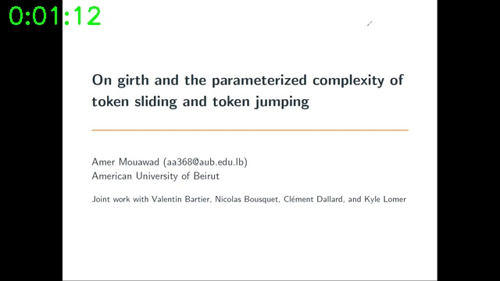


Result 2 - Score: 0.2679
Segment ID: 8
Time range: 64.00s - 74.00s
Keyframe path: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_72.00.jpg
Keyframe timestamp: 72.00s


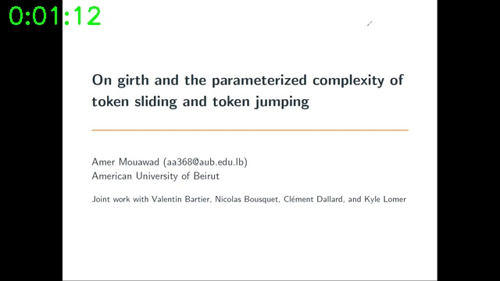


Result 3 - Score: 0.2671
Segment ID: 6
Time range: 48.00s - 58.00s
Keyframe path: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_54.00.jpg
Keyframe timestamp: 54.00s


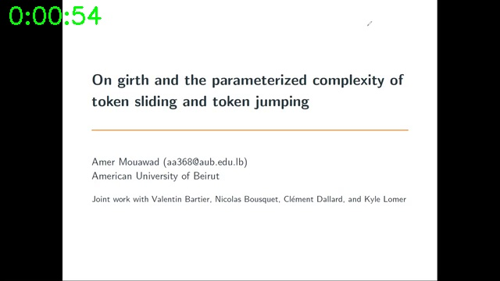

In [ ]:
def test_faiss_image_retrieval(output_dir, json_path):
    print("\n--- Testing FAISS Image Retrieval ---")
    with open(json_path, "r") as f:
        data = json.load(f)
    first_qa = data["qa"][0]
    query_text = first_qa["question"]
    true_answers = first_qa["answer"]
    print(f"Query: '{query_text}'\n")
    print("True Answer(s):")
    for answer in true_answers:
        print(f"Time: {answer['start_time']} - {answer['end_time']}")
        print(f"Text: {answer['text']}\n")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if torch.cuda.is_available() else torch.float32
    image_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).to(dtype)
    image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    inputs = image_processor(text=[query_text], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        text_features = image_model.get_text_features(**inputs)
    query_embedding = text_features[0].cpu().numpy()
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    retrieval_system = FAISSImageRetrieval(output_dir)
    retrieval_system.build_index()
    results = retrieval_system.search(query_embedding, top_k=3)
    if results:
        print(f"Retrieved {len(results)} result(s):")
        for i, result in enumerate(results):
            print(f"\nResult {i+1} - Score: {result['score']:.4f}")
            print(f"Segment ID: {result['segment_id']}")
            print(f"Time range: {result['start_time']:.2f}s - {result['end_time']:.2f}s")
            print(f"Keyframe path: {result['keyframe_path']}")
            print(f"Keyframe timestamp: {result['keyframe_timestamp']:.2f}s")
            try:
                img = Image.open(result['keyframe_path'])
                img.thumbnail((500, 500))
                display(img)
            except Exception as e:
                print(f"Error displaying image for result {i+1}: {e}")
    else:
        print("No results found.")
    return results

json_path = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/Questions/First_set.json"
output_dir = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset"
results = test_faiss_image_retrieval(output_dir, json_path)

In [6]:
class FAISSFusionRetrieval(RetrievalSystem):

    def __init__(self, output_dir: str):
        super().__init__("FAISS (Flat) - Fusion", output_dir, modality="fusion")
        self.text_index = None
        self.image_index = None
        self.text_id_mapping = {}
        self.image_id_mapping = {}
        self.visual_terms = [
            "show", "display", "image", "graph", "diagram", "slide",
            "visual", "screen", "figure", "picture", "drawing", "see", "look"
        ]
        self.technical_terms = [
            "token", "sliding", "jumping", "algorithm", "complexity",
            "graph", "reconfiguration", "parameterized", "theorem", "explain",
            "definition", "concept", "technique"
        ]

    def analyze_query_type(self, query: str) -> Dict[str, Any]:
        query_lower = query.lower()
        if any(term in query_lower for term in self.visual_terms):
            return {"type": "Visual", "text_weight": 0.3, "image_weight": 0.7}
        elif any(term in query_lower for term in self.technical_terms):
            return {"type": "Technical", "text_weight": 0.8, "image_weight": 0.2}
        else:
            return {"type": "General", "text_weight": 0.6, "image_weight": 0.4}

    def build_index(self):
        start_time = time.time()
        text_embeddings = []
        self.text_id_mapping = {}
        for idx, (segment_id, data) in enumerate(self.text_embeddings.items()):
            embedding = np.array(data["embedding"], dtype=np.float32)
            text_embeddings.append(embedding)
            self.text_id_mapping[idx] = segment_id
        if text_embeddings:
            text_embeddings = np.array(text_embeddings, dtype=np.float32)
            self.text_index = faiss.IndexFlatIP(text_embeddings.shape[1])
            self.text_index.add(text_embeddings)
            print(f"FAISS text index built with {len(self.text_id_mapping)} vectors.")
        else:
            self.text_index = None
            print("No text embeddings available to build text index.")
        image_embeddings = []
        self.image_id_mapping = {}
        idx = 0
        for segment_id, data in self.image_embeddings.items():
            for keyframe in data["keyframes"]:
                embedding = np.array(keyframe["embedding"], dtype=np.float32)
                image_embeddings.append(embedding)
                self.image_id_mapping[idx] = {
                    "segment_id": segment_id,
                    "keyframe_path": keyframe["path"],
                    "timestamp": keyframe["timestamp"]
                }
                idx += 1
        if image_embeddings:
            image_embeddings = np.array(image_embeddings, dtype=np.float32)
            self.image_index = faiss.IndexFlatIP(image_embeddings.shape[1])
            self.image_index.add(image_embeddings)
            print(f"FAISS image index built with {len(self.image_id_mapping)} vectors.")
        else:
            self.image_index = None
            print("No image embeddings available to build image index.")
        self.setup_time = time.time() - start_time
        self.is_ready = True
        print(f"FAISS fusion indices built. Setup time: {self.setup_time:.2f}s")

    def normalize_scores(self, score_dict: Dict[int, float]) -> Dict[int, float]:
        if not score_dict:
            return {}
        values = list(score_dict.values())
        max_score = max(values)
        min_score = min(values)
        if max_score == min_score:
            return {k: 1.0 for k in score_dict}
        return {k: (v - min_score) / (max_score - min_score) for k, v in score_dict.items()}

    def search(self, query_data: Dict, top_k: int = 5) -> List[Dict]:
        if not self.is_ready:
            self.build_index()
        query_text = query_data["text"]
        query_text_embedding = query_data["text_embedding"]
        query_image_embedding = query_data["image_embedding"]
        query_analysis = self.analyze_query_type(query_text)
        text_weight = query_analysis["text_weight"]
        image_weight = query_analysis["image_weight"]
        print(f"Query type: {query_analysis['type']}")
        print(f"Weights: Text {text_weight:.2f}, Image {image_weight:.2f}")
        text_scores = {}
        if self.text_index is not None:
            scores, indices = self.text_index.search(
                np.array([query_text_embedding], dtype=np.float32),
                min(top_k * 2, len(self.text_id_mapping))
            )
            for idx, score in zip(indices[0], scores[0]):
                if 0 <= idx < len(self.text_id_mapping):
                    segment_id = self.text_id_mapping[idx]
                    text_scores[segment_id] = float(score)
        image_scores = {}
        segment_keyframes = {}
        if self.image_index is not None:
            scores, indices = self.image_index.search(
                np.array([query_image_embedding], dtype=np.float32),
                min(top_k * 3, len(self.image_id_mapping))
            )
            for idx, score in zip(indices[0], scores[0]):
                if 0 <= idx < len(self.image_id_mapping):
                    info = self.image_id_mapping[idx]
                    segment_id = info["segment_id"]
                    if segment_id not in image_scores or score > image_scores[segment_id]:
                        image_scores[segment_id] = float(score)
                        segment_keyframes[segment_id] = info
        text_scores = self.normalize_scores(text_scores)
        image_scores = self.normalize_scores(image_scores)
        combined_scores = {}
        for segment_id, score in text_scores.items():
            combined_scores[segment_id] = score * text_weight
        for segment_id, score in image_scores.items():
            if segment_id in combined_scores:
                combined_scores[segment_id] += score * image_weight
            else:
                combined_scores[segment_id] = score * image_weight
        top_segments = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
        results = []
        for segment_id, score in top_segments:
            result = {
                "segment_id": int(segment_id),
                "score": float(score),
                "fusion_weights": {"text": text_weight, "image": image_weight},
                "modality": "fusion"
            }
            if segment_id in self.text_embeddings:
                segment_data = self.text_embeddings[segment_id]
                result.update({
                    "start_time": segment_data["start_time"],
                    "end_time": segment_data["end_time"],
                    "text": segment_data["text"],
                    "text_score": text_scores.get(segment_id, 0.0) * text_weight
                })
            if segment_id in segment_keyframes:
                keyframe_info = segment_keyframes[segment_id]
                result.update({
                    "keyframe_path": keyframe_info["keyframe_path"],
                    "keyframe_timestamp": keyframe_info["timestamp"],
                    "image_score": image_scores.get(segment_id, 0.0) * image_weight
                })
            results.append(result)
        return results

In [ ]:
def test_faiss_fusion_retrieval(output_dir, json_path):
    print("\n--- Testing FAISS Fusion Retrieval ---")
    with open(json_path, "r") as f:
        data = json.load(f)
    first_qa = data["qa"][0]
    query_text = first_qa["question"]
    true_answers = first_qa["answer"]
    print(f"Query: '{query_text}'\n")
    print("True Answer(s):")
    for answer in true_answers:
        print(f"Time: {answer['start_time']} - {answer['end_time']}")
        print(f"Text: {answer['text']}\n")
    text_model = SentenceTransformer("ibm-granite/granite-embedding-107m-multilingual")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if torch.cuda.is_available() else torch.float32
    image_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).to(dtype)
    image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    text_embedding = text_model.encode(query_text)
    inputs = image_processor(text=[query_text], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        text_features = image_model.get_text_features(**inputs)
    image_embedding = text_features[0].cpu().numpy()
    image_embedding = image_embedding / np.linalg.norm(image_embedding)
    query_data = {
        "text": query_text,
        "text_embedding": text_embedding,
        "image_embedding": image_embedding
    }
    retrieval_system = FAISSFusionRetrieval(output_dir)
    retrieval_system.build_index()
    print(f"Searching for: '{query_text}'")
    results = retrieval_system.search(query_data, top_k=3)
    if results:
        print(f"Found {len(results)} results:")
        for i, result in enumerate(results):
            print(f"\nResult {i+1} - Score: {result['score']:.4f}")
            print(f"Segment ID: {result['segment_id']}")
            print(f"Time range: {result['start_time']:.2f}s - {result['end_time']:.2f}s")
            print(f"Text score: {result.get('text_score', 0):.4f}")
            print(f"Image score: {result.get('image_score', 0):.4f}")
            print(f"Fusion weights: Text {result['fusion_weights']['text']:.2f}, Image {result['fusion_weights']['image']:.2f}")
            print(f"Text snippet: {result['text'][:100]}...")
            if 'keyframe_path' in result:
                print(f"Keyframe: {result['keyframe_path']}")
    else:
        print("No results found.")
    return results

json_path = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/Questions/First_set.json"
output_dir = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset"
results = test_faiss_fusion_retrieval(output_dir, json_path)


--- Testing FAISS Fusion Retrieval ---
Query: 'Who is the student among the co-authors?'

True Answer(s):
Time: 101.0 - 112.9090909090909
Text: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right.

Loaded 330 text embeddings
Loaded image embeddings for 467 segments
FAISS text index built with 330 vectors.
FAISS image index built with 1712 vectors.
FAISS fusion indices built. Setup time: 0.05s
Searching for: 'Who is the student among the co-authors?'
Query type: General
Weights: Text 0.60, Image 0.40
Found 3 results:

Result 1 - Score: 1.0000
Segment ID: 8
Time range: 101.00s - 112.91s
Text score: 0.6000
Image score: 0.4000
Fusion weights: Text 0.60, Image 0.40
Text snippet: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is...
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_72.00.jpg

Result 2 - Score: 0.4316
Segment 

### PostgreSQL - Semantic Retrieval

In [9]:
!apt-get update
!apt-get install -y postgresql postgresql-contrib
!pg_config --version
!service postgresql start
!apt-get install -y postgresql-server-dev-$(pg_config --version | cut -d' ' -f2 | cut -d'.' -f1)
!apt-get install -y build-essential git
!git clone https://github.com/pgvector/pgvector.git
%cd pgvector
!make && make install
%cd ..
!find /etc -name "pg_hba.conf"


pg_hba_path = subprocess.check_output("find /etc -name pg_hba.conf", shell=True).decode().strip()
print(f"Found PostgreSQL config at: {pg_hba_path}")
if pg_hba_path:
    !echo "host all all 127.0.0.1/32 trust" | sudo tee -a {pg_hba_path}
    !echo "local all all trust" | sudo tee -a {pg_hba_path}
    !service postgresql restart
else:
    print("Could not find pg_hba.conf file!")

!sudo -u postgres psql -c "ALTER USER postgres WITH PASSWORD 'postgres';"
!sudo -u postgres psql -c "DROP DATABASE IF EXISTS videorag;"
!sudo -u postgres psql -c "CREATE DATABASE videorag;"
!sudo -u postgres psql -c '\c videorag; CREATE EXTENSION IF NOT EXISTS vector;'

try:
    conn = psycopg2.connect(
        host="localhost",
        database="videorag",
        user="postgres",
        password="postgres"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT version();")
    version = cursor.fetchone()[0]
    print(f"Connected to PostgreSQL: {version}")
    cursor.execute("CREATE TABLE IF NOT EXISTS vector_test (id serial PRIMARY KEY, embedding vector(3));")
    cursor.execute("INSERT INTO vector_test (embedding) VALUES ('[1,2,3]');")
    cursor.execute("SELECT * FROM vector_test LIMIT 1;")
    result = cursor.fetchone()
    print(f"pgvector test successful: {result}")
    cursor.close()
    conn.close()
    print("PostgreSQL with pgvector is ready!")
except Exception as e:
    print(f"Error: {str(e)}")
    print("\nTroubleshooting tips:")
    print("1. Check if PostgreSQL is running: !service postgresql status")
    print("2. Verify if pgvector was installed correctly")
    print("3. Check database connection parameters")

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,245 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,901 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packa

In [ ]:
!sudo -u postgres psql -d videorag -c "CREATE EXTENSION IF NOT EXISTS vector;"
!sudo -u postgres psql -d videorag -c "SELECT '[1,2,3]'::vector;"
!sudo -u postgres psql -d videorag -c "CREATE TABLE IF NOT EXISTS vector_test (id serial PRIMARY KEY, embedding vector(3));"
!sudo -u postgres psql -d videorag -c "INSERT INTO vector_test (embedding) VALUES ('[1,2,3]');"
!sudo -u postgres psql -d videorag -c "SELECT * FROM vector_test;"

CREATE EXTENSION
 vector  
---------
 [1,2,3]
(1 row)

>8CREATE TABLE
INSERT 0 1
 id | embedding 
----+-----------
  1 | [1,2,3]
(1 row)

>8

In [10]:
class PgVectorTextRetrieval(RetrievalSystem):

    def __init__(self, output_dir: str, index_type: str = "ivfflat"):
        index_name = f"PgVector ({index_type.upper()}) - Text"
        super().__init__(index_name, output_dir, modality="text")
        self.index_type = index_type
        self.conn = None
        self.embedding_dim = None
        self.table_name = f"video_segments_text_{index_type}"

    def _connect_db(self):
        try:
            self.conn = psycopg2.connect(
                host="localhost",
                database="videorag",
                user="postgres",
                password="postgres"
            )
            return True
        except Exception as e:
            print(f"Database connection error: {str(e)}")
            return False

    def build_index(self):
        start_time = time.time()
        if not self._connect_db():
            print("Failed to connect to database. Skipping pgvector index.")
            return
        if not self.embeddings:
            print("No text embeddings available")
            return
        first_key = next(iter(self.embeddings))
        self.embedding_dim = len(self.embeddings[first_key]["embedding"])

        try:
            cursor = self.conn.cursor()
            cursor.execute("CREATE EXTENSION IF NOT EXISTS vector")
            cursor.execute(f"DROP TABLE IF EXISTS {self.table_name}")
            cursor.execute(f"""
                CREATE TABLE {self.table_name} (
                    id SERIAL PRIMARY KEY,
                    segment_id INTEGER,
                    start_time FLOAT,
                    end_time FLOAT,
                    text TEXT,
                    embedding vector({self.embedding_dim})
                )
            """)
            for segment_id, data in self.embeddings.items():
                vector_str = str(data["embedding"]).replace(' ', '')
                cursor.execute(f"""
                    INSERT INTO {self.table_name} (segment_id, start_time, end_time, text, embedding)
                    VALUES (%s, %s, %s, %s, %s::vector)
                """, (
                    int(segment_id),
                    data["start_time"],
                    data["end_time"],
                    data["text"],
                    vector_str
                ))
            if self.index_type.lower() == "ivfflat":
                lists = max(10, len(self.embeddings) // 100)
                cursor.execute(f"""
                    CREATE INDEX ON {self.table_name}
                    USING ivfflat (embedding vector_cosine_ops)
                    WITH (lists = {lists})
                """)
            elif self.index_type.lower() == "hnsw":
                cursor.execute(f"""
                    CREATE INDEX ON {self.table_name}
                    USING hnsw (embedding vector_cosine_ops)
                    WITH (m = 16, ef_construction = 64)
                """)

            self.conn.commit()
            cursor.close()
            self.setup_time = time.time() - start_time
            self.is_ready = True
            print(f"PgVector {self.index_type} text index built with {len(self.embeddings)} vectors. Setup time: {self.setup_time:.2f}s")
        except Exception as e:
            print(f"Error building pgvector index: {str(e)}")
            if self.conn:
                self.conn.rollback()

    def search(self, query_embedding: np.ndarray, top_k: int = 5) -> List[Dict]:
        if not self.is_ready:
            self.build_index()
        if not self.conn:
            print("Database connection not available")
            return []
        try:
            cursor = self.conn.cursor()
            query_vector_str = str(query_embedding.tolist()).replace(' ', '')

            cursor.execute(f"""
                SELECT segment_id, start_time, end_time, text,
                       1 - (embedding <=> %s::vector) as score
                FROM {self.table_name}
                ORDER BY score DESC
                LIMIT %s
            """, (query_vector_str, top_k))

            results = []
            for segment_id, start_time, end_time, text, score in cursor.fetchall():
                results.append({
                    "segment_id": segment_id,
                    "score": float(score),
                    "start_time": start_time,
                    "end_time": end_time,
                    "text": text,
                    "modality": "text"
                })
            cursor.close()
            return results
        except Exception as e:
            print(f"Error searching pgvector index: {str(e)}")
            if self.conn:
                self.conn.rollback()
            return []

In [11]:
class PgVectorImageRetrieval(RetrievalSystem):

    def __init__(self, output_dir: str, index_type: str = "ivfflat"):
        index_name = f"PgVector ({index_type.upper()}) - Image"
        super().__init__(index_name, output_dir, modality="image")
        self.index_type = index_type
        self.conn = None
        self.embedding_dim = None
        self.table_name = f"video_keyframes_{index_type}"

    def _connect_db(self):
        try:
            self.conn = psycopg2.connect(
                host="localhost",
                database="videorag",
                user="postgres",
                password="postgres"
            )
            return True
        except Exception as e:
            print(f"Database connection error: {str(e)}")
            return False

    def build_index(self):
        start_time = time.time()
        if not self._connect_db():
            print("Failed to connect to database. Skipping pgvector index.")
            return
        if not self.embeddings:
            print("No image embeddings available")
            return
        sample_dim = None
        for segment_id, data in self.embeddings.items():
            if data["keyframes"]:
                sample_dim = len(data["keyframes"][0]["embedding"])
                break
        if sample_dim is None:
            print("No keyframe embeddings found")
            return

        self.embedding_dim = sample_dim

        try:
            cursor = self.conn.cursor()
            cursor.execute("CREATE EXTENSION IF NOT EXISTS vector")
            cursor.execute(f"DROP TABLE IF EXISTS {self.table_name}")
            cursor.execute(f"""
                CREATE TABLE {self.table_name} (
                    id SERIAL PRIMARY KEY,
                    segment_id INTEGER,
                    keyframe_path TEXT,
                    timestamp FLOAT,
                    start_time FLOAT,
                    end_time FLOAT,
                    embedding vector({self.embedding_dim})
                )
            """)
            for segment_id, data in self.embeddings.items():
                segment_start = data.get("start_time")
                segment_end = data.get("end_time")
                for keyframe in data["keyframes"]:
                    vector_str = str(keyframe["embedding"]).replace(' ', '')
                    cursor.execute(f"""
                        INSERT INTO {self.table_name}
                        (segment_id, keyframe_path, timestamp, start_time, end_time, embedding)
                        VALUES (%s, %s, %s, %s, %s, %s::vector)
                    """, (
                        int(segment_id),
                        keyframe["path"],
                        keyframe["timestamp"],
                        segment_start,
                        segment_end,
                        vector_str
                    ))
            if self.index_type.lower() == "ivfflat":
                lists = max(10, len(self.embeddings) // 100)
                cursor.execute(f"""
                    CREATE INDEX ON {self.table_name}
                    USING ivfflat (embedding vector_cosine_ops)
                    WITH (lists = {lists})
                """)
            elif self.index_type.lower() == "hnsw":
                cursor.execute(f"""
                    CREATE INDEX ON {self.table_name}
                    USING hnsw (embedding vector_cosine_ops)
                    WITH (m = 16, ef_construction = 64)
                """)
            self.conn.commit()
            cursor.close()
            self.setup_time = time.time() - start_time
            self.is_ready = True
            print(f"PgVector {self.index_type} image index built. Setup time: {self.setup_time:.2f}s")
        except Exception as e:
            print(f"Error building pgvector index: {str(e)}")
            if self.conn:
                self.conn.rollback()

    def search(self, query_embedding: np.ndarray, top_k: int = 5) -> List[Dict]:
        if not self.is_ready:
            self.build_index()
        if not self.conn:
            print("Database connection not available")
            return []
        try:
            cursor = self.conn.cursor()
            query_vector_str = str(query_embedding.tolist()).replace(' ', '')
            cursor.execute(f"""
                SELECT segment_id, keyframe_path, timestamp, start_time, end_time,
                       1 - (embedding <=> %s::vector) as score
                FROM {self.table_name}
                ORDER BY score DESC
                LIMIT %s
            """, (query_vector_str, top_k * 3))
            segment_scores = {}
            segment_keyframes = {}
            for segment_id, keyframe_path, timestamp, start_time, end_time, score in cursor.fetchall():
                if segment_id not in segment_scores or score > segment_scores[segment_id]:
                    segment_scores[segment_id] = score
                    segment_keyframes[segment_id] = {
                        "keyframe_path": keyframe_path,
                        "timestamp": timestamp,
                        "start_time": start_time,
                        "end_time": end_time
                    }
            results = []
            for segment_id, score in sorted(segment_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]:
                keyframe_info = segment_keyframes[segment_id]
                results.append({
                    "segment_id": segment_id,
                    "score": float(score),
                    "start_time": keyframe_info["start_time"],
                    "end_time": keyframe_info["end_time"],
                    "keyframe_path": keyframe_info["keyframe_path"],
                    "keyframe_timestamp": keyframe_info["timestamp"],
                    "modality": "image"
                })
            cursor.close()
            return results
        except Exception as e:
            print(f"Error searching pgvector index: {str(e)}")
            if self.conn:
                self.conn.rollback()
            return []

In [12]:
json_path = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/Questions/First_set.json"
output_dir = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset"

In [ ]:
def test_pgvector_retrieval(output_dir, json_path, modality="text", index_type="ivfflat"):
    print(f"--- Testing PgVector ({index_type.upper()}) {modality.capitalize()} Retrieval ---")

    with open(json_path, "r") as f:
        data = json.load(f)
    first_qa = data["qa"][0]
    query_text = first_qa["question"]
    true_answers = first_qa["answer"]
    print(f"Query: '{query_text}'\n")
    print("True Answer(s):")
    for answer in true_answers:
        start_time = answer.get('start', answer.get('start_time', 0))
        end_time = answer.get('end', answer.get('end_time', 0))
        print(f"Time: {start_time} - {end_time}")
        print(f"Text: {answer['text']}\n")
    if modality in ["text", "fusion"]:
        text_model = SentenceTransformer("ibm-granite/granite-embedding-107m-multilingual")
        query_text_embedding = text_model.encode(query_text)
        query_text_embedding = query_text_embedding / np.linalg.norm(query_text_embedding)
    if modality in ["image", "fusion"]:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        dtype = torch.float16 if torch.cuda.is_available() else torch.float32
        image_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).to(dtype)
        image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        inputs = image_processor(text=[query_text], return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            text_features = image_model.get_text_features(**inputs)
        query_image_embedding = text_features[0].cpu().numpy()
        query_image_embedding = query_image_embedding / np.linalg.norm(query_image_embedding)

    if modality == "text":
        retrieval_system = PgVectorTextRetrieval(output_dir, index_type=index_type)
        retrieval_system.build_index()
        print(f"Searching for: '{query_text}'")
        results = retrieval_system.search(query_text_embedding, top_k=3)
    elif modality == "image":
        retrieval_system = PgVectorImageRetrieval(output_dir, index_type=index_type)
        retrieval_system.build_index()
        print(f"Searching for: '{query_text}'")
        results = retrieval_system.search(query_image_embedding, top_k=3)
    elif modality == "fusion":
        print("Fusion retrieval not yet implemented for PgVector in this test")
        return None

    if results:
        print(f"Found {len(results)} results:")
        for i, result in enumerate(results):
            print(f"\nResult {i+1} - Score: {result['score']:.4f}")
            print(f"Segment ID: {result['segment_id']}")
            print(f"Time range: {result['start_time']:.2f}s - {result['end_time']:.2f}s")
            if modality == "text" or "text" in result:
                print(f"Text snippet: {result['text'][:100]}...")
            if modality == "image" and "keyframe_path" in result:
                print(f"Keyframe: {result['keyframe_path']}")
                print(f"Keyframe timestamp: {result['keyframe_timestamp']:.2f}s")
                try:
                    img = Image.open(result['keyframe_path'])
                    img.thumbnail((300, 300))
                    display(img)
                except Exception as e:
                    print(f"Could not display image: {e}")
        print("\n--- Evaluation against Ground Truth ---")
        for i, result in enumerate(results):
            result_start, result_end = result["start_time"], result["end_time"]
            for answer in true_answers:
                ans_start = answer.get('start', answer.get('start_time', 0))
                ans_end = answer.get('end', answer.get('end_time', 0))
                if max(result_start, ans_start) <= min(result_end, ans_end):
                    print(f"✓ Result {i+1} MATCHES true answer at time {ans_start}-{ans_end}")
                    break
            else:
                print(f"✗ Result {i+1} does NOT match any true answers")
    else:
        print("No results found.")
    return results

In [ ]:
def count_matches(results, true_answers):
    if not results:
        return 0
    matches = 0
    for result in results:
        result_start, result_end = result["start_time"], result["end_time"]
        for answer in true_answers:
            ans_start = answer.get('start', answer.get('start_time', 0))
            ans_end = answer.get('end', answer.get('end_time', 0))
            if max(result_start, ans_start) <= min(result_end, ans_end):
                matches += 1
                break
    return matches

In [ ]:
def run_pgvector_tests(output_dir, json_path):
    print("\n==== Running PgVector Retrieval Tests ====")
    with open(json_path, "r") as f:
        data = json.load(f)
    true_answers = data["qa"][0]["answer"]
    text_ivfflat_results = test_pgvector_retrieval(output_dir, json_path, modality="text", index_type="ivfflat")
    text_hnsw_results = test_pgvector_retrieval(output_dir, json_path, modality="text", index_type="hnsw")
    image_ivfflat_results = test_pgvector_retrieval(output_dir, json_path, modality="image", index_type="ivfflat")
    image_hnsw_results = test_pgvector_retrieval(output_dir, json_path, modality="image", index_type="hnsw")
    print("\n==== PgVector Retrieval Results Summary ====")
    print(f"Text IVFFLAT matches: {count_matches(text_ivfflat_results, true_answers)}")
    print(f"Text HNSW matches: {count_matches(text_hnsw_results, true_answers)}")
    print(f"Image IVFFLAT matches: {count_matches(image_ivfflat_results, true_answers)}")
    print(f"Image HNSW matches: {count_matches(image_hnsw_results, true_answers)}")


==== Running PgVector Retrieval Tests ====
--- Testing PgVector (IVFFLAT) Text Retrieval ---
Query: 'Who is the student among the co-authors?'

True Answer(s):
Time: 101.0 - 112.9090909090909
Text: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right.



modules.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/611k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/697 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/214M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Loaded 330 text embeddings
PgVector ivfflat text index built with 330 vectors. Setup time: 0.26s
Searching for: 'Who is the student among the co-authors?'
Found 3 results:

Result 1 - Score: 0.7201
Segment ID: 8
Time range: 101.00s - 112.91s
Text snippet: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is...

Result 2 - Score: 0.6962
Segment ID: 322
Time range: 3683.60s - 3690.34s
Text snippet: Yeah. So yeah. Yes, I can. Most other questions. That's all that I have to say. So I can share it wi...

Result 3 - Score: 0.6709
Segment ID: 324
Time range: 3697.10s - 3705.01s
Text snippet: but we have already shared a link on the page where students can go and go through some previous lec...

--- Evaluation against Ground Truth ---
✓ Result 1 MATCHES true answer at time 101.0-112.9090909090909
✗ Result 2 does NOT match any true answers
✗ Result 3 does NOT match any true answers
--- Testing PgVector (HNSW) Text Retrieval ---
Query: 'Who is the 

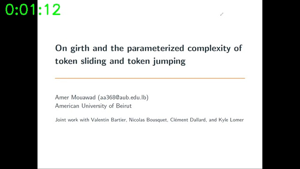


Result 2 - Score: 0.2678
Segment ID: 4
Time range: 53.00s - 69.93s
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_69.00.jpg
Keyframe timestamp: 69.00s


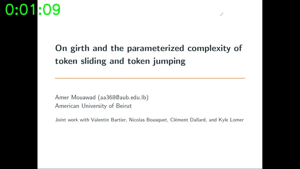


Result 3 - Score: 0.2670
Segment ID: 3
Time range: 42.00s - 52.93s
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_48.00.jpg
Keyframe timestamp: 48.00s


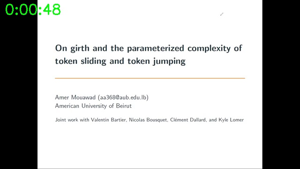


--- Evaluation against Ground Truth ---
✗ Result 1 does NOT match any true answers
✗ Result 2 does NOT match any true answers
✗ Result 3 does NOT match any true answers
--- Testing PgVector (HNSW) Image Retrieval ---
Query: 'Who is the student among the co-authors?'

True Answer(s):
Time: 101.0 - 112.9090909090909
Text: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right.

Loaded image embeddings for 329 segments
PgVector hnsw image index built. Setup time: 1.96s
Searching for: 'Who is the student among the co-authors?'
Found 3 results:

Result 1 - Score: 0.2679
Segment ID: 5
Time range: 70.00s - 80.93s
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_72.00.jpg
Keyframe timestamp: 72.00s


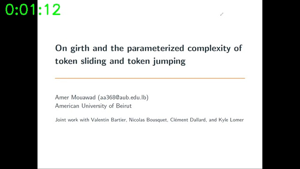


Result 2 - Score: 0.2678
Segment ID: 4
Time range: 53.00s - 69.93s
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_69.00.jpg
Keyframe timestamp: 69.00s


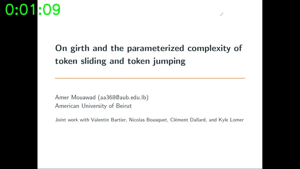


Result 3 - Score: 0.2670
Segment ID: 3
Time range: 42.00s - 52.93s
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_48.00.jpg
Keyframe timestamp: 48.00s


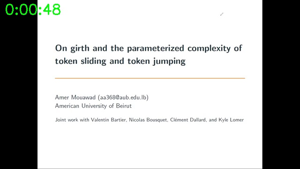


--- Evaluation against Ground Truth ---
✗ Result 1 does NOT match any true answers
✗ Result 2 does NOT match any true answers
✗ Result 3 does NOT match any true answers

==== PgVector Retrieval Results Summary ====
Text IVFFLAT matches: 1
Text HNSW matches: 1
Image IVFFLAT matches: 0
Image HNSW matches: 0


In [ ]:
run_pgvector_tests(output_dir, json_path)

In [13]:
class PgVectorFusionRetrieval(RetrievalSystem):

    def __init__(self, output_dir: str, index_type: str = "ivfflat"):
        index_name = f"PgVector ({index_type.upper()}) - Fusion"
        super().__init__(index_name, output_dir, modality="fusion")
        self.index_type = index_type
        self.conn = None
        self.text_table = f"video_segments_text_{index_type}"
        self.image_table = f"video_keyframes_{index_type}"
        self.visual_terms = [
            "show", "display", "image", "graph", "diagram", "slide",
            "visual", "screen", "figure", "picture", "drawing", "see", "look"
        ]
        self.technical_terms = [
            "token", "sliding", "jumping", "algorithm", "complexity",
            "graph", "reconfiguration", "parameterized", "theorem", "explain",
            "definition", "concept", "technique"
        ]

    def analyze_query_type(self, query: str) -> Dict[str, Any]:
        query_lower = query.lower()
        if any(term in query_lower for term in self.visual_terms):
            return {
                "type": "Visual",
                "text_weight": 0.3,
                "image_weight": 0.7
            }
        elif any(term in query_lower for term in self.technical_terms):
            return {
                "type": "Technical",
                "text_weight": 0.8,
                "image_weight": 0.2
            }
        else:
            return {
                "type": "General",
                "text_weight": 0.6,
                "image_weight": 0.4
            }

    def _connect_db(self):
        try:
            self.conn = psycopg2.connect(
                host="localhost",
                database="videorag",
                user="postgres",
                password="postgres"
            )
            return True
        except Exception as e:
            print(f"Database connection error: {str(e)}")
            return False

    def build_index(self):
        start_time = time.time()
        if not self._connect_db():
            print("Failed to connect to database. Skipping pgvector fusion.")
            return
        try:
            cursor = self.conn.cursor()
            cursor.execute(f"""
                SELECT EXISTS (
                   SELECT FROM information_schema.tables
                   WHERE table_name = '{self.text_table}'
                )
            """)
            text_table_exists = cursor.fetchone()[0]
            cursor.execute(f"""
                SELECT EXISTS (
                   SELECT FROM information_schema.tables
                   WHERE table_name = '{self.image_table}'
                )
            """)
            image_table_exists = cursor.fetchone()[0]
            cursor.close()
            if not text_table_exists:
                print(f"Text table {self.text_table} does not exist")
                print("Please build PgVectorTextRetrieval first")
                return
            if not image_table_exists:
                print(f"Image table {self.image_table} does not exist")
                print("Please build PgVectorImageRetrieval first")
                return
            self.setup_time = time.time() - start_time
            self.is_ready = True
            print(f"PgVector fusion ready. Setup time: {self.setup_time:.2f}s")
        except Exception as e:
            print(f"Error checking pgvector tables: {str(e)}")
            if self.conn:
                self.conn.rollback()

    def search(self, query_data: Dict, top_k: int = 5) -> List[Dict]:
        if not self.is_ready:
            self.build_index()
        if not self.conn:
            print("Database connection not available")
            return []
        query_text = query_data["text"]
        query_text_embedding = query_data["text_embedding"]
        query_image_embedding = query_data["image_embedding"]
        query_analysis = self.analyze_query_type(query_text)
        text_weight = query_analysis["text_weight"]
        image_weight = query_analysis["image_weight"]
        print(f"Query type: {query_analysis['type']}")
        print(f"Weights: Text {text_weight:.2f}, Image {image_weight:.2f}")
        try:
            cursor = self.conn.cursor()
            text_emb_str = str(query_text_embedding.tolist()).replace(' ', '')
            image_emb_str = str(query_image_embedding.tolist()).replace(' ', '')

            cursor.execute(f"""
                WITH text_scores AS (
                    SELECT
                        segment_id,
                        text,
                        start_time,
                        end_time,
                        1 - (embedding <=> %s::vector) as text_score
                    FROM {self.text_table}
                ),
                image_scores AS (
                    SELECT
                        segment_id,
                        keyframe_path,
                        timestamp as keyframe_timestamp,
                        1 - (embedding <=> %s::vector) as image_score
                    FROM {self.image_table}
                    ORDER BY image_score DESC
                ),
                -- Rest of the query remains the same
                best_keyframes AS (
                    SELECT DISTINCT ON (segment_id)
                        segment_id,
                        keyframe_path,
                        keyframe_timestamp,
                        image_score
                    FROM image_scores
                    ORDER BY segment_id, image_score DESC
                ),
                text_norm AS (
                    SELECT
                        segment_id,
                        text,
                        start_time,
                        end_time,
                        (text_score - MIN(text_score) OVER()) /
                        NULLIF((MAX(text_score) OVER() - MIN(text_score) OVER()), 0) as norm_text_score
                    FROM text_scores
                ),
                image_norm AS (
                    SELECT
                        segment_id,
                        keyframe_path,
                        keyframe_timestamp,
                        (image_score - MIN(image_score) OVER()) /
                        NULLIF((MAX(image_score) OVER() - MIN(image_score) OVER()), 0) as norm_image_score
                    FROM best_keyframes
                ),
                combined_scores AS (
                    SELECT
                        t.segment_id,
                        t.text,
                        t.start_time,
                        t.end_time,
                        t.norm_text_score * %s as weighted_text_score,
                        i.keyframe_path,
                        i.keyframe_timestamp,
                        COALESCE(i.norm_image_score * %s, 0) as weighted_image_score
                    FROM text_norm t
                    LEFT JOIN image_norm i ON t.segment_id = i.segment_id
                ),
                final_scores AS (
                    SELECT
                        segment_id,
                        text,
                        start_time,
                        end_time,
                        weighted_text_score,
                        keyframe_path,
                        keyframe_timestamp,
                        weighted_image_score,
                        (weighted_text_score + COALESCE(weighted_image_score, 0)) as total_score
                    FROM combined_scores
                )
                SELECT * FROM final_scores
                ORDER BY total_score DESC
                LIMIT %s
            """, (
                text_emb_str,
                image_emb_str,
                text_weight,
                image_weight,
                top_k
            ))
            results = []
            for row in cursor.fetchall():
                segment_id, text, start_time, end_time, text_score, keyframe_path, keyframe_timestamp, image_score, total_score = row
                result = {
                    "segment_id": segment_id,
                    "score": float(total_score),
                    "start_time": start_time,
                    "end_time": end_time,
                    "text": text,
                    "text_score": float(text_score),
                    "fusion_weights": {
                        "text": text_weight,
                        "image": image_weight
                    },
                    "modality": "fusion"
                }
                if keyframe_path:
                    result["keyframe_path"] = keyframe_path
                    result["keyframe_timestamp"] = keyframe_timestamp
                    result["image_score"] = float(image_score)
                results.append(result)
            cursor.close()
            return results

        except Exception as e:
            print(f"Error with fusion search: {str(e)}")
            if self.conn:
                self.conn.rollback()
            return []

        except Exception as e:
            print(f"Error with fusion search: {str(e)}")
            if self.conn:
                self.conn.rollback()
            return []


==== Testing PgVector Fusion Retrieval ====

--- Testing PgVector (IVFFLAT) Fusion Retrieval ---
Query: 'Who is the student among the co-authors?'

True Answer(s):
Time: 101.0 - 112.9090909090909
Text: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right.

Loaded 330 text embeddings
Loaded image embeddings for 329 segments
PgVector fusion ready. Setup time: 0.01s
Searching for: 'Who is the student among the co-authors?'
Query type: General
Weights: Text 0.60, Image 0.40
Found 3 results:

Result 1 - Total Score: 0.9701
Segment ID: 8
Time range: 101.00s - 112.91s
Text score: 0.6000 (weight: 0.60)
Image score: 0.3701 (weight: 0.40)
Text snippet: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right....
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_108.00.jpg
Keyframe timestamp: 108.00s


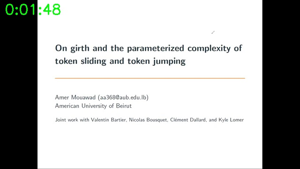


Result 2 - Total Score: 0.7760
Segment ID: 0
Time range: 0.00s - 15.24s
Text score: 0.3962 (weight: 0.60)
Image score: 0.3799 (weight: 0.40)
Text snippet: So hello everyone, welcome to the PC seminar. Today we have with us Professor Amir Mawad from American University of Beirut, and he'll be talking on t...
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_6.00.jpg
Keyframe timestamp: 6.00s


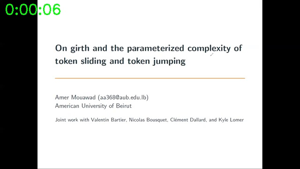


Result 3 - Total Score: 0.7576
Segment ID: 1
Time range: 15.31s - 24.93s
Text score: 0.3847 (weight: 0.60)
Image score: 0.3729 (weight: 0.40)
Text snippet: Thank you for joining us, Professor. Over to you now. Thank you, Prasivathai. Thank you for having me. It's a real pleasure to be here....
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_24.00.jpg
Keyframe timestamp: 24.00s


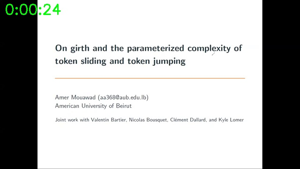


--- Evaluation against Ground Truth ---
✓ Result 1 MATCHES true answer at time 101.0-112.9090909090909
✗ Result 2 does NOT match any true answers
✗ Result 3 does NOT match any true answers

--- Testing PgVector (HNSW) Fusion Retrieval ---
Query: 'Who is the student among the co-authors?'

True Answer(s):
Time: 101.0 - 112.9090909090909
Text: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right.

Loaded 330 text embeddings
Loaded image embeddings for 329 segments
PgVector fusion ready. Setup time: 0.02s
Searching for: 'Who is the student among the co-authors?'
Query type: General
Weights: Text 0.60, Image 0.40
Found 3 results:

Result 1 - Total Score: 0.9701
Segment ID: 8
Time range: 101.00s - 112.91s
Text score: 0.6000 (weight: 0.60)
Image score: 0.3701 (weight: 0.40)
Text snippet: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All r

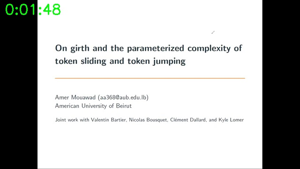


Result 2 - Total Score: 0.7760
Segment ID: 0
Time range: 0.00s - 15.24s
Text score: 0.3962 (weight: 0.60)
Image score: 0.3799 (weight: 0.40)
Text snippet: So hello everyone, welcome to the PC seminar. Today we have with us Professor Amir Mawad from American University of Beirut, and he'll be talking on t...
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_6.00.jpg
Keyframe timestamp: 6.00s


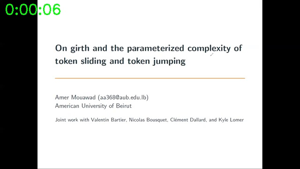


Result 3 - Total Score: 0.7576
Segment ID: 1
Time range: 15.31s - 24.93s
Text score: 0.3847 (weight: 0.60)
Image score: 0.3729 (weight: 0.40)
Text snippet: Thank you for joining us, Professor. Over to you now. Thank you, Prasivathai. Thank you for having me. It's a real pleasure to be here....
Keyframe: /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/frames/frame_24.00.jpg
Keyframe timestamp: 24.00s


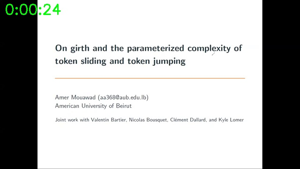


--- Evaluation against Ground Truth ---
✓ Result 1 MATCHES true answer at time 101.0-112.9090909090909
✗ Result 2 does NOT match any true answers
✗ Result 3 does NOT match any true answers

==== Fusion Retrieval Results Summary ====
Fusion IVFFLAT matches: 1
Fusion HNSW matches: 1


In [ ]:
def test_pgvector_fusion_retrieval(output_dir, json_path, index_type="ivfflat"):
    print(f"--- Testing PgVector ({index_type.upper()}) Fusion Retrieval ---")
    with open(json_path, "r") as f:
        data = json.load(f)
    first_qa = data["qa"][0]
    query_text = first_qa["question"]
    true_answers = first_qa["answer"]
    print(f"Query: '{query_text}'\n")
    print("True Answer(s):")
    for answer in true_answers:
        start_time = answer.get('start', answer.get('start_time', 0))
        end_time = answer.get('end', answer.get('end_time', 0))
        print(f"Time: {start_time} - {end_time}")
        print(f"Text: {answer['text']}\n")
    text_model = SentenceTransformer("ibm-granite/granite-embedding-107m-multilingual")
    query_text_embedding = text_model.encode(query_text)
    query_text_embedding = query_text_embedding / np.linalg.norm(query_text_embedding)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if torch.cuda.is_available() else torch.float32
    image_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).to(dtype)
    image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    inputs = image_processor(text=[query_text], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        text_features = image_model.get_text_features(**inputs)
    query_image_embedding = text_features[0].cpu().numpy()
    query_image_embedding = query_image_embedding / np.linalg.norm(query_image_embedding)
    query_data = {
        "text": query_text,
        "text_embedding": query_text_embedding,
        "image_embedding": query_image_embedding
    }
    retrieval_system = PgVectorFusionRetrieval(output_dir, index_type=index_type)
    retrieval_system.build_index()
    print(f"Searching for: '{query_text}'")
    results = retrieval_system.search(query_data, top_k=3)
    if results:
        print(f"Found {len(results)} results:")
        for i, result in enumerate(results):
            print(f"\nResult {i+1} - Total Score: {result['score']:.4f}")
            print(f"Segment ID: {result['segment_id']}")
            print(f"Time range: {result['start_time']:.2f}s - {result['end_time']:.2f}s")
            print(f"Text score: {result['text_score']:.4f} (weight: {result['fusion_weights']['text']:.2f})")
            if 'image_score' in result:
                print(f"Image score: {result['image_score']:.4f} (weight: {result['fusion_weights']['image']:.2f})")
            else:
                print(f"No image match for this segment (weight: {result['fusion_weights']['image']:.2f})")
            print(f"Text snippet: {result['text'][:150]}...")
            if 'keyframe_path' in result:
                print(f"Keyframe: {result['keyframe_path']}")
                print(f"Keyframe timestamp: {result['keyframe_timestamp']:.2f}s")
                try:
                    img = Image.open(result['keyframe_path'])
                    img.thumbnail((300, 300))
                    display(img)
                except Exception as e:
                    print(f"Could not display image: {e}")
        print("\n--- Evaluation against Ground Truth ---")
        for i, result in enumerate(results):
            result_start, result_end = result["start_time"], result["end_time"]
            for answer in true_answers:
                ans_start = answer.get('start', answer.get('start_time', 0))
                ans_end = answer.get('end', answer.get('end_time', 0))
                if max(result_start, ans_start) <= min(result_end, ans_end):
                    print(f"✓ Result {i+1} MATCHES true answer at time {ans_start}-{ans_end}")
                    break
            else:
                print(f"✗ Result {i+1} does NOT match any true answers")
    else:
        print("No results found.")
    return results

def run_fusion_tests(output_dir, json_path):
    print("\n==== Testing PgVector Fusion Retrieval ====")
    ivfflat_results = test_pgvector_fusion_retrieval(output_dir, json_path, index_type="ivfflat")
    hnsw_results = test_pgvector_fusion_retrieval(output_dir, json_path, index_type="hnsw")
    with open(json_path, "r") as f:
        data = json.load(f)
    true_answers = data["qa"][0]["answer"]
    ivfflat_matches = count_matches(ivfflat_results, true_answers)
    hnsw_matches = count_matches(hnsw_results, true_answers)
    print("\n==== Fusion Retrieval Results Summary ====")
    print(f"Fusion IVFFLAT matches: {ivfflat_matches}")
    print(f"Fusion HNSW matches: {hnsw_matches}")
    return {
        "ivfflat": ivfflat_results,
        "hnsw": hnsw_results
    }

json_path = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/Questions/First_set.json"
output_dir = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset"
fusion_results = run_fusion_tests(output_dir, json_path)

### TF-IDF - Lexical Retreival

In [7]:
class TFIDF:
    def __init__(self, transcript_path):
        self.transcript_path = transcript_path
        self.segments = []
        self.vectorizer = None
        self.document_vectors = None
        self.is_ready = False

    def load_segments(self):
        with open(self.transcript_path, 'r') as f:
            data = json.load(f)

        if isinstance(data, list):
            self.segments = data
        elif "segments" in data:
            self.segments = []
            for i, seg in enumerate(data["segments"]):
                self.segments.append({
                    "id": i,
                    "start_time": seg["start"],
                    "end_time": seg["end"],
                    "text": seg["text"]
                })
        print(f"Loaded {len(self.segments)} segments")

    def build_index(self):
        if not self.segments:
            self.load_segments()
        from sklearn.feature_extraction.text import TfidfVectorizer
        texts = [segment["text"] for segment in self.segments]
        self.vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=1,
            max_df=0.9,
            token_pattern=r'\b\w+[\w\'-]*\w+\b|[\w\'-]+'
        )
        self.document_vectors = self.vectorizer.fit_transform(texts)
        self.is_ready = True
        vocab_size = len(self.vectorizer.get_feature_names_out())
        print(f"TF-IDF index built with {len(texts)} documents and {vocab_size} terms")

    def search(self, query, top_k=5):
        if not self.is_ready:
            self.build_index()
        query_vector = self.vectorizer.transform([query])
        scores = (query_vector @ self.document_vectors.T).toarray()[0]
        top_indices = scores.argsort()[-top_k:][::-1]
        results = []
        for idx in top_indices:
            segment = self.segments[idx]
            if scores[idx] > 0:
                results.append({
                    "segment_id": segment["id"],
                    "score": float(scores[idx]),
                    "start_time": segment["start_time"],
                    "end_time": segment["end_time"],
                    "text": segment["text"],
                    "modality": "text"
                })
        return results

In [ ]:
def test_tfidf(transcript_path, json_path):
    print("--- Testing Simple General-Purpose TF-IDF ---")
    with open(json_path, "r") as f:
        data = json.load(f)
    first_qa = data["qa"][0]
    query_text = first_qa["question"]
    true_answers = first_qa["answer"]
    print(f"Query: '{query_text}'\n")
    retrieval = TFIDF(transcript_path)
    retrieval.build_index()
    print(f"Searching for: '{query_text}'")
    results = retrieval.search(query_text, top_k=3)
    if results:
        print(f"Found {len(results)} results:")
        for i, result in enumerate(results):
            print(f"\nResult {i+1} - Score: {result['score']:.6f}")
            print(f"Segment ID: {result['segment_id']}")
            print(f"Time range: {result['start_time']:.2f}s - {result['end_time']:.2f}s")
            print(f"Text snippet: {result['text'][:150]}...")
        print("\n--- Evaluation against Ground Truth ---")
        for i, result in enumerate(results):
            result_start, result_end = result["start_time"], result["end_time"]
            for answer in true_answers:
                ans_start = answer.get('start', answer.get('start_time', 0))
                ans_end = answer.get('end', answer.get('end_time', 0))
                if max(result_start, ans_start) <= min(result_end, ans_end):
                    print(f"✓ Result {i+1} MATCHES true answer at time {ans_start}-{ans_end}")
                    break
            else:
                print(f"✗ Result {i+1} does NOT match any true answers")
    else:
        print("No results found.")

    return results

processed_transcript_path = f"{output_dir}/processed/segments_with_keyframes.json"
simple_tfidf_results = test_tfidf(processed_transcript_path, json_path)

--- Testing Simple General-Purpose TF-IDF ---
Query: 'Who is the student among the co-authors?'

Loaded 330 segments
TF-IDF index built with 330 documents and 3582 terms
Searching for: 'Who is the student among the co-authors?'
Found 1 results:

Result 1 - Score: 0.200239
Segment ID: 8
Time range: 101.00s - 112.91s
Text snippet: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right....

--- Evaluation against Ground Truth ---
✓ Result 1 MATCHES true answer at time 101.0-112.9090909090909


### BM25 - Lexical Retrieval

In [8]:
class BM25(RetrievalSystem):
    def __init__(self, output_dir: str):
        super().__init__("BM25", output_dir, modality="text")
        self.bm25 = None
        self.segment_ids = []
        self.tokenized_corpus = []

    def tokenize_text(self, text):
        import re
        from nltk.corpus import stopwords
        try:
            stops = stopwords.words('english')
        except:
            import nltk
            nltk.download('stopwords')
            stops = stopwords.words('english')
        tokens = re.findall(r'\b\w+[\w\'-]*\w+\b|[\w\'-]+', text.lower())
        tokens = [t for t in tokens if t not in stops and len(t) > 1]
        return tokens

    def build_index(self):
        start_time = time.time()
        texts = []
        self.segment_ids = []
        for segment_id, data in self.embeddings.items():
            texts.append(data["text"])
            self.segment_ids.append(segment_id)
        self.tokenized_corpus = [self.tokenize_text(text) for text in texts]
        self.bm25 = BM25Okapi(self.tokenized_corpus)
        self.setup_time = time.time() - start_time
        self.is_ready = True
        print(f"Improved BM25 index built with {len(texts)} documents. Setup time: {self.setup_time:.2f}s")

    def search(self, query: str, top_k: int = 5) -> List[Dict]:
        if not self.is_ready:
            self.build_index()
        tokenized_query = self.tokenize_text(query)
        scores = self.bm25.get_scores(tokenized_query)
        top_indices = scores.argsort()[-top_k:][::-1]
        results = []
        for idx in top_indices:
            if scores[idx] > 0:
                segment_id = self.segment_ids[idx]
                segment_data = self.embeddings[segment_id]
                results.append({
                    "segment_id": int(segment_id),
                    "score": float(scores[idx]),
                    "start_time": segment_data["start_time"],
                    "end_time": segment_data["end_time"],
                    "text": segment_data["text"],
                    "modality": "text"
                })
        return results

In [ ]:
def test_bm25(output_dir, json_path):
    print("--- Testing Improved BM25 Text Retrieval ---")
    with open(json_path, "r") as f:
        data = json.load(f)
    first_qa = data["qa"][0]
    query_text = first_qa["question"]
    true_answers = first_qa["answer"]
    print(f"Query: '{query_text}'\n")
    print("True Answer(s):")
    for answer in true_answers:
        start_time = answer.get('start', answer.get('start_time', 0))
        end_time = answer.get('end', answer.get('end_time', 0))
        print(f"Time: {start_time} - {end_time}")
        print(f"Text: {answer['text']}\n")
    retrieval_system = BM25(output_dir)
    retrieval_system.build_index()
    print(f"Searching for: '{query_text}'")
    results = retrieval_system.search(query_text, top_k=3)
    if results:
        print(f"Found {len(results)} results:")
        for i, result in enumerate(results):
            print(f"\nResult {i+1} - Score: {result['score']:.4f}")
            print(f"Segment ID: {result['segment_id']}")
            print(f"Time range: {result['start_time']:.2f}s - {result['end_time']:.2f}s")
            print(f"Text snippet: {result['text'][:150]}...")
        print("\n--- Evaluation against Ground Truth ---")
        matches = 0
        for i, result in enumerate(results):
            result_start, result_end = result["start_time"], result["end_time"]
            for answer in true_answers:
                ans_start = answer.get('start', answer.get('start_time', 0))
                ans_end = answer.get('end', answer.get('end_time', 0))
                if max(result_start, ans_start) <= min(result_end, ans_end):
                    print(f"✓ Result {i+1} MATCHES true answer at time {ans_start}-{ans_end}")
                    matches += 1
                    break
            else:
                print(f"✗ Result {i+1} does NOT match any true answers")
        print(f"\nImproved BM25 found {matches} out of {len(true_answers)} true answers")
    else:
        print("No results found.")
    return results

json_path = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/Questions/First_set.json"
output_dir = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset"
bm25_results = test_bm25(output_dir, json_path)

--- Testing Improved BM25 Text Retrieval ---
Query: 'Who is the student among the co-authors?'

True Answer(s):
Time: 101.0 - 112.9090909090909
Text: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right.

Loaded 330 text embeddings
Improved BM25 index built with 330 documents. Setup time: 0.05s
Searching for: 'Who is the student among the co-authors?'
Found 1 results:

Result 1 - Score: 5.2724
Segment ID: 8
Time range: 101.00s - 112.91s
Text snippet: And it's joint work with Valentin Barchet, Nicolas Bousquet, Clément Dallard, and Kyle Lomer, who is my master's student. All right....

--- Evaluation against Ground Truth ---
✓ Result 1 MATCHES true answer at time 101.0-112.9090909090909

Improved BM25 found 1 out of 1 true answers


## Step 5: The RAG System

In [16]:
class VideoRAGSystem:
    def __init__(self, output_dir, video_path):
        self.output_dir = output_dir
        self.video_path = video_path
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        print("Loading FLAN-T5-large model")
        try:
            self.llm_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
            self.llm_model = T5ForConditionalGeneration.from_pretrained(
                "google/flan-t5-large",
                device_map="auto"
            )
            self.model_size = "large"
            print(f"✅ FLAN-T5-large loaded successfully")
            self.model_loaded = True
        except Exception as e:
            print(f"⚠️ Error loading FLAN-T5-large: {e}")
            print("Trying to load FLAN-T5-base as fallback...")
            try:
                self.llm_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
                self.llm_model = T5ForConditionalGeneration.from_pretrained(
                    "google/flan-t5-base",
                    device_map="auto"
                )
                self.model_size = "base"
                print("✅ FLAN-T5-base loaded successfully as fallback")
                self.model_loaded = True
            except Exception as e2:
                print(f"⚠️ Error loading FLAN-T5-base: {e2}")
                print("Trying to load FLAN-T5-small...")
                try:
                    self.llm_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
                    self.llm_model = T5ForConditionalGeneration.from_pretrained(
                        "google/flan-t5-small",
                        device_map="auto"
                    )
                    self.model_size = "small"
                    print("✅ FLAN-T5-small loaded successfully")
                    self.model_loaded = True
                except Exception as e3:
                    print(f"❌ Error loading any FLAN-T5 model: {e3}")
                    print("System will operate in retrieval-only mode")
                    self.llm_tokenizer = None
                    self.llm_model = None
                    self.model_size = None
                    self.model_loaded = False

        print("Loading embedding models...")
        try:
            self.text_model = SentenceTransformer("ibm-granite/granite-embedding-107m-multilingual")
            print("✅ SentenceTransformer loaded successfully")
        except Exception as e:
            print(f"❌ Error loading SentenceTransformer: {e}")
            print("Trying to load a fallback embedding model...")
            try:
                self.text_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
                print("✅ Fallback SentenceTransformer loaded")
            except Exception as e2:
                print(f"❌ Critical error: Could not load any embedding model: {e2}")
                raise RuntimeError("Cannot continue without an embedding model")

        try:
            self.image_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(self.device)
            self.image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
            print("✅ CLIP model loaded successfully")
        except Exception as e:
            print(f"⚠️ Error loading CLIP model: {e}")
            print("System will operate without image embeddings")
            self.image_model = None
            self.image_processor = None

        print("Initializing retrieval systems...")
        self.retrieval_systems = {}

        print("Setting up FAISS systems...")
        self.retrieval_systems["faiss_text"] = FAISSTextRetrieval(output_dir)
        if self.image_model is not None:
            self.retrieval_systems["faiss_image"] = FAISSImageRetrieval(output_dir)
            self.retrieval_systems["faiss_fusion"] = FAISSFusionRetrieval(output_dir)

        print("Setting up lexical retrieval systems...")
        try:
            transcript_path = f"{output_dir}/processed/segments_with_keyframes.json"
            self.retrieval_systems["tfidf"] = TFIDF(transcript_path)
            print("✅ TFIDF initialized")

            print("Initializing BM25...")
            self.retrieval_systems["bm25"] = BM25(output_dir)
            print("✅ BM25 initialized")
        except Exception as e:
            print(f"⚠️ Error initializing lexical systems: {e}")

        for name, system in list(self.retrieval_systems.items()):
            try:
                print(f"Building index for {name}...")
                system.build_index()
                print(f"✅ {name} index built successfully")
            except Exception as e:
                print(f"❌ Error building index for {name}: {e}")
                if name in self.retrieval_systems:
                    del self.retrieval_systems[name]

        print(f"✅ Successfully initialized {len(self.retrieval_systems)} retrieval systems")
        self.generation_log = []

    def generate_with_flan(self, prompt, max_length=150):
        if not self.model_loaded:
            return "No language model available"

        try:
            inputs = self.llm_tokenizer(prompt, return_tensors="pt").to(self.llm_model.device)
            if hasattr(self.llm_tokenizer, 'model_max_length') and inputs.input_ids.shape[1] > self.llm_tokenizer.model_max_length:
                print(f"⚠️ Prompt exceeds model's token limit, truncating...")
                inputs = self.llm_tokenizer(
                    prompt,
                    return_tensors="pt",
                    truncation=True,
                    max_length=self.llm_tokenizer.model_max_length - 10
                ).to(self.llm_model.device)
            with torch.no_grad():
                output = self.llm_model.generate(
                    input_ids=inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    max_length=max_length,
                    num_beams=3,
                    do_sample=False,
                    temperature=0.3,
                    repetition_penalty=1.5
                )

            response = self.llm_tokenizer.decode(output[0], skip_special_tokens=True)
            return response

        except Exception as e:
            print(f"Error generating with FLAN-T5: {e}")
            return None

    def rewrite_query(self, query):
        prompt = f"""Given this question: "{query}"
        Rewrite it to be clear and concise for a retrieval system searching through video transcripts.
        If the original query is already clear, return EXACTLY the same query.
        Focus on identifying key search terms and maintaining the original intent.
        Rewritten query:"""

        try:
            start_time = time.time()
            rewritten = self.generate_with_flan(prompt, max_length=60)
            elapsed = time.time() - start_time
            # similarity = difflib.SequenceMatcher(None, query.lower(), rewritten.lower()).ratio()
            # if similarity > 0.8:
            #     return query
            print(f"Rewritten from '{query}' to '{rewritten}' in {elapsed:.2f}s")
            return rewritten.strip()
        except Exception as e:
            print(f"Error rewriting query: {e}")
            return query

    def expand_query(self, query):
        return query

    def embed_query(self, query):
        result = {"text": query}
        text_embedding = self.text_model.encode(query)
        text_embedding = text_embedding / np.linalg.norm(text_embedding)
        result["text_embedding"] = text_embedding

        if self.image_model is not None and self.image_processor is not None:
            max_tokens = 70
            if len(query.split()) > 20:
                truncated_query = " ".join(query.split()[:20])
                print(f"Query truncated for CLIP: {truncated_query}")
            else:
                truncated_query = query

            inputs = self.image_processor(text=[truncated_query], return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            with torch.no_grad():
                image_embedding = self.image_model.get_text_features(**inputs)[0].cpu().numpy()
            image_embedding = image_embedding / np.linalg.norm(image_embedding)
            result["image_embedding"] = image_embedding

        return result

    def retrieve_with_system(self, name, system, query, embedded_query, top_k=1):
        try:
            start_time = time.time()
            if name == "faiss_text":
                results = system.search(embedded_query["text_embedding"], top_k=top_k)
            elif name == "faiss_image":
                if "image_embedding" not in embedded_query:
                    return []
                results = system.search(embedded_query["image_embedding"], top_k=top_k)
            elif name == "tfidf":
                results = system.search(query, top_k=top_k)
            elif name == "bm25":
                results = system.search(query, top_k=top_k)
            else:
                results = system.search(embedded_query, top_k=top_k)
            retrieval_time = (time.time() - start_time) * 1000
            if results:
                for result in results:
                    result['retrieval_time'] = retrieval_time
                    if 'start_time' not in result:
                        result['start_time'] = 0.0
                    if 'end_time' not in result:
                        result['end_time'] = 0.0
                    if 'text' not in result:
                        result['text'] = "No text available for this segment"
                    if 'score' not in result:
                        result['score'] = 1.0

            return results
        except Exception as e:
            print(f"Error with {name} retrieval: {e}")
            return []

    def retrieve_all(self, query, top_k=1):
        results = {}
        embedded_query = self.embed_query(query)

        retriever_weights = {
            "tfidf": 2.0,
            "bm25": 2.0,
            "faiss_text": 0.6,
            "faiss_image": 0.5,
            "faiss_fusion": 0.7
        }

        for name, system in self.retrieval_systems.items():
            try:
                print(f"Retrieving with {name}...")
                system_results = self.retrieve_with_system(name, system, query, embedded_query, top_k=1)
                if system_results and len(system_results) > 0:
                    segment = system_results[0]
                    if segment.get('text') == "No text available for this segment" or len(segment.get('text', '').strip()) < 5:
                        print(f"  ✗ Result from {name} has no meaningful text")
                        continue
                    weight = retriever_weights.get(name, 1.0)
                    segment['original_score'] = segment['score']
                    segment['score'] = segment['score'] * weight
                    segment['retriever'] = name
                    results[name] = segment
                    print(f"  ✓ Got result from {name} at time {segment['start_time']:.2f}s-{segment['end_time']:.2f}s")
                    print(f"    Score: {segment['score']:.4f} (original: {segment['original_score']:.4f}, weight: {weight})")
                else:
                    print(f"  ✗ No results from {name}")
            except Exception as e:
                print(f"  ⚠️ Error with {name} retrieval: {e}")
        return results

    def format_segments_for_llm(self, segments_dict, max_context_length=1200):
        if not segments_dict:
            return ""
        segments = [(name, segment) for name, segment in segments_dict.items()]
        segments.sort(key=lambda x: x[1].get('score', 0), reverse=True)
        context = ""
        current_length = 0
        for i, (system_name, segment) in enumerate(segments):
            text = segment.get('text', "No text available for this segment")
            segment_text = f"{text}\n\n"
            segment_length = len(segment_text)
            if current_length + segment_length <= max_context_length:
                context += segment_text
                current_length += segment_length
            else:
                remaining_space = max_context_length - current_length
                if remaining_space > 50:
                    shortened_text = text[:remaining_space - 5] + "..."
                    context += f"{shortened_text}\n\n"
                break
        return context

    def expand_timespan(self, start_time, end_time, buffer_seconds=10.0):
        return (max(0, start_time - buffer_seconds), end_time + buffer_seconds)

    def generate_answer(self, query, segments_dict):
        if not segments_dict:
            return {
                "answer": "I couldn't find relevant information in the video to answer your question.",
                "has_answer": False,
                "segments": {},
                "timespan": None
            }
        context = self.format_segments_for_llm(segments_dict)
        try:
            if self.model_loaded:
              #4. If the CONTEXT doesn't contain ANY information to answer, respond with "i don't have enough information"
                prompt = f"""You are an AI assistant answering questions about a video based ONLY on the provided context from the video transcript.

CONTEXT FROM VIDEO:
{context}

QUESTION: {query}

INSTRUCTIONS:
1. Answer ONLY based on the information in the CONTEXT above. NOTE: The context might include more information than necessary, only use WHAT IS NECESSARY
2. Be concise and specific, focusing only on what's mentioned in the context.
3. Do not use knowledge from outside the provided context.

YOUR ANSWER:"""
                print("\n📝 Answer generation prompt:")
                print("-" * 80)
                print(f"Context length: {len(context)} characters, {len(context.split())} words")
                print(f"Question: {query}")
                print("-" * 80)
                gen_start_time = time.time()
                answer_text = self.generate_with_flan(prompt, max_length=120)
                gen_time = time.time() - gen_start_time
                print(f"✨ Generated answer in {gen_time:.2f}s: {answer_text}")
                print("-" * 80)
                self.generation_log.append({
                    "type": "answer_generation",
                    "query": query,
                    "answer": answer_text,
                    "gen_time": gen_time,
                    "model": f"flan-t5-{self.model_size}",
                    "num_segments": len(segments_dict),
                    "context_length": len(context)
                })
            else:
                first_segment = list(segments_dict.values())[0]
                answer_text = first_segment.get('text', "No text available")
                print("⚠️ Using raw segment text as no model is available")
            answer_text = self.clean_response(answer_text)
            no_answer_phrases = [
                "i don't have enough information",
                "i do not have enough information"
            ]
            has_answer = not any(phrase in answer_text.lower() for phrase in no_answer_phrases)
            if segments_dict:
                first_segment = list(segments_dict.values())[0]
                timespan = (
                    first_segment.get('start_time', 0),
                    first_segment.get('end_time', 0)
                )
                expanded_timespan = self.expand_timespan(*timespan)
            else:
                timespan = None
                expanded_timespan = None

            return {
                "answer": answer_text,
                "has_answer": has_answer,
                "segments": segments_dict,
                "timespan": timespan,
                "expanded_timespan": expanded_timespan
            }

        except Exception as e:
            print(f"Error generating answer: {e}")
            import traceback
            traceback.print_exc()
            return {
                "answer": f"Error generating answer: {e}",
                "has_answer": False,
                "segments": segments_dict,
                "timespan": None
            }

    def clean_response(self, response):
        if not response:
            return "No response generated"
        response = response.strip()
        if "Do not include segment numbers" in response:
            response = response.split("Do not include segment numbers")[0].strip()
        response = re.sub(r'SEGMENT \d+:', '', response)
        response = re.sub(r'SEGMENT \d+ \(\d+\.\d+s - \d+\.\d+s\):', '', response)
        response = re.sub(r'\[Video Segment \d+\]', '', response)
        response = re.sub(r'\[Segment \d+\]', '', response)
        response = re.sub(r'\(Timestamp: \d+\.\d+s - \d+\.\d+s\)', '', response)
        response = re.sub(r'\(\s*\):', '', response)
        response = re.sub(r'\(\s*\)', '', response)
        response = re.sub(r'\s+', ' ', response)
        words = response.split()
        for length in range(5, 20):
            if len(words) < length*2:
                continue
            for i in range(len(words) - length*2 + 1):
                phrase1 = " ".join(words[i:i+length])
                phrase2 = " ".join(words[i+length:i+length*2])
                if phrase1 == phrase2:
                    response = response.replace(phrase1 + " " + phrase2, phrase1)
                    return self.clean_response(response)
        response = re.sub(r'\s+', ' ', response).strip()
        return response

    def answer_question(self, query, top_k=1):
        print(f"\n📝 Processing query: {query}")
        sys.stdout.flush()
        rewritten_query = self.rewrite_query(query)
        if rewritten_query != query:
            print(f"🔄 Rewritten query: {rewritten_query}")
        query = rewritten_query
        embedded_query = self.embed_query(query)
        print("\n🔍 Results per retrieval system:")
        system_results = {}
        all_segments = {}
        for name, system in self.retrieval_systems.items():
            print(f"\n=== {name.upper()} ===")
            try:
                retrieval_results = self.retrieve_with_system(name, system, query, embedded_query, top_k=top_k)
                if not retrieval_results or len(retrieval_results) == 0:
                    print(f"❌ No results found with {name}")
                    system_results[name] = {
                        "answer": f"Could not find relevant information using {name}.",
                        "has_answer": False,
                        "timespan": None,
                        "segments": {}
                    }
                    continue
                top_segment = retrieval_results[0]
                print(f"✓ Found segment at time {top_segment['start_time']:.2f}s-{top_segment['end_time']:.2f}s")
                print(f"  Score: {top_segment['score']:.4f}")

                print(f"\n📑 Retrieved text:")
                print(f"{'-'*50}")
                print(top_segment.get('text', 'No text available'))
                print(f"{'-'*50}")

                segment_id = f"{name}_{top_segment.get('segment_id', 0)}"
                all_segments[segment_id] = top_segment
                system_segments = {segment_id: top_segment}

                print(f"🧠 Generating answer with {name}...")
                result = self.generate_answer(query, system_segments)

                system_results[name] = {
                    "answer": result["answer"],
                    "has_answer": result["has_answer"],
                    "timespan": result["timespan"],
                    "expanded_timespan": result.get("expanded_timespan"),
                    "segments": system_segments
                }

                print(f"\n✨ {name} answer: {result['answer']}")
                if result["timespan"]:
                    start, end = result["timespan"]
                    print(f"⏱️ Timespan: {start:.2f}s - {end:.2f}s")

            except Exception as e:
                print(f"⚠️ Error with {name}: {e}")
                import traceback
                traceback.print_exc()
                system_results[name] = {
                    "answer": f"Error processing with {name}: {str(e)}",
                    "has_answer": False,
                    "timespan": None,
                    "segments": {}
                }

        return {
            "answer": f"Multiple answers generated - see system_results",
            "has_answer": any(res["has_answer"] for res in system_results.values()),
            "segments": all_segments,
            "system_results": system_results,
            "timespan": None,
        }

    def print_generation_stats(self):
        if not self.generation_log:
            print("No generation statistics available")
            return
        rewrites = [g for g in self.generation_log if g["type"] == "query_rewrite"]
        answers = [g for g in self.generation_log if g["type"] == "answer_generation"]
        print("\n" + "="*80)
        print("📊 GENERATION STATISTICS")
        print("="*80)
        if rewrites:
            print("\n📝 QUERY REWRITES:")
            print(f"Total rewrites: {len(rewrites)}")
            print(f"Model used: {rewrites[0].get('model', 'unknown')}")
            for i, rewrite in enumerate(rewrites):
                print(f"\n{i+1}. Original: \"{rewrite['original']}\"")
                print(f"   Rewritten: \"{rewrite['rewritten']}\"")
        if answers:
            print("\n🔍 ANSWER GENERATIONS:")
            print(f"Total answer generations: {len(answers)}")
            print(f"Model used: {answers[0].get('model', 'unknown')}")
            avg_time = sum(a["gen_time"] for a in answers) / len(answers)
            avg_segments = sum(a["num_segments"] for a in answers) / len(answers)
            avg_context = sum(a["context_length"] for a in answers) / len(answers)
            print(f"Average generation time: {avg_time:.2f}s")
            print(f"Average segments per question: {avg_segments:.1f}")
            print(f"Average context length: {avg_context:.1f} characters")
            for i, answer in enumerate(answers):
                print(f"\n{i+1}. Query: \"{answer['query']}\"")
                print(f"   Answer: \"{answer['answer']}\"")
                print(f"   Generation time: {answer['gen_time']:.2f}s")
        print("\n" + "="*80)

In [17]:
def evaluate_video_rag_system(answerable_results, unanswerable_results, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    metrics = {
        "accuracy": {},
        "rejection": {},
        "retrieval_comparison": {},
        "overall": {},
        "query_transformation": {}
    }
    print("\n=== Evaluating RAG System Performance ===")
    all_results = answerable_results + (unanswerable_results or [])
    try:
        # try:
        #     from __main__ import analyze_retrieval_scores, integrate_score_analysis_into_evaluation
        # except ImportError:
        #     def analyze_retrieval_scores(all_results, output_dir):
        #         print("Score analysis function not properly imported. Using placeholder.")
        #         return {"score_stats": {}}

        #     def integrate_score_analysis_into_evaluation(metrics, score_analysis, output_dir):
        #         return metrics

        print("Analyzing retrieval scores in detail...")
        score_analysis = analyze_retrieval_scores(all_results, output_dir)
        print(f"Score analysis complete. Generated visualizations in {output_dir}")
    except Exception as e:
        print(f"Warning: Detailed score analysis failed: {e}")
        import traceback
        traceback.print_exc()
        score_analysis = {"score_stats": {}}

    original_queries = []
    rewritten_queries = []
    expanded_queries = []
    query_diff_ratios = []

    for result in all_results:
        if all(key in result for key in ["original_query", "rewritten_query", "expanded_query"]):
            original = result["original_query"]
            rewritten = result["rewritten_query"]
            expanded = result["expanded_query"]

            original_queries.append(original)
            rewritten_queries.append(rewritten)
            expanded_queries.append(expanded)

            import difflib
            if original != rewritten:
                diff_ratio = difflib.SequenceMatcher(None, original, rewritten).ratio()
                query_diff_ratios.append(diff_ratio)

    if query_diff_ratios:
        avg_diff_ratio = sum(query_diff_ratios) / len(query_diff_ratios)
        metrics["query_transformation"]["avg_diff_ratio"] = avg_diff_ratio
        metrics["query_transformation"]["query_count"] = len(original_queries)
        metrics["query_transformation"]["rewritten_count"] = sum(1 for o, r in zip(original_queries, rewritten_queries) if o != r)
        print(f"Query transformation: {metrics['query_transformation']['rewritten_count']}/{len(original_queries)} queries were rewritten")
        print(f"Average difference ratio: {avg_diff_ratio:.2f}")

    if answerable_results:
        system_matches = {}
        system_questions_answered = {}

        for result in answerable_results:
            if "system_results" in result:
                for system_name, system_result in result["system_results"].items():
                    if system_name not in system_questions_answered:
                        system_questions_answered[system_name] = 0
                        system_matches[system_name] = 0
                    system_questions_answered[system_name] += 1
                    if result.get("system_matches", {}).get(system_name, []):
                        system_matches[system_name] += 1
            else:
                matching_systems = set()
                for system_name, _, _ in result.get("all_matches", []):
                    matching_systems.add(system_name)
                for system_name in matching_systems:
                    if system_name not in system_matches:
                        system_matches[system_name] = 0
                        system_questions_answered[system_name] = 0
                    system_matches[system_name] += 1
                    system_questions_answered[system_name] += 1
        questions_with_matches = sum(1 for result in answerable_results if result.get("matches", 0) > 0)
        accuracy = questions_with_matches / len(answerable_results) if len(answerable_results) > 0 else 0

        system_accuracy = {}
        for system_name, matches in system_matches.items():
            questions = system_questions_answered.get(system_name, len(answerable_results))
            system_accuracy[system_name] = matches / questions if questions > 0 else 0
        metrics["accuracy"]["overall"] = accuracy
        metrics["accuracy"]["per_system"] = system_accuracy
        metrics["accuracy"]["questions_with_matches"] = questions_with_matches
        metrics["accuracy"]["total_questions"] = len(answerable_results)
        print(f"Accuracy on answerable questions: {accuracy:.2f} ({questions_with_matches}/{len(answerable_results)})")

        if system_accuracy:
            plt.figure(figsize=(10, 6))
            systems = list(system_accuracy.keys())
            accuracies = [system_accuracy[sys] for sys in systems]
            sorted_indices = np.argsort(accuracies)[::-1]
            systems = [systems[i] for i in sorted_indices]
            accuracies = [accuracies[i] for i in sorted_indices]
            colors = plt.cm.viridis(np.linspace(0, 0.8, len(systems)))
            plt.bar(systems, accuracies, color=colors)
            plt.axhline(y=accuracy, color='r', linestyle='-', label=f'Overall Accuracy: {accuracy:.2f}')
            plt.xlabel('Retrieval System')
            plt.ylabel('Accuracy')
            plt.title('Accuracy per Retrieval System')
            plt.xticks(rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'accuracy_per_system.png'))
            plt.show()
            plt.close()
            print(f"Saved accuracy visualization to {output_dir}/accuracy_per_system.png")

    if unanswerable_results:
        system_rejections = {}
        system_unanswerable_questions = {}
        for result in unanswerable_results:
            if "system_results" in result:
                for system_name, system_result in result["system_results"].items():
                    if system_name not in system_unanswerable_questions:
                        system_unanswerable_questions[system_name] = 0
                        system_rejections[system_name] = 0
                    system_unanswerable_questions[system_name] += 1
                    if not system_result.get("has_answer", True):
                        system_rejections[system_name] += 1
            else:
                if not result.get("has_answer", True):
                    for system_name in result.get("segments", {}).keys():
                        if system_name not in system_rejections:
                            system_rejections[system_name] = 0
                            system_unanswerable_questions[system_name] = 0
                        system_rejections[system_name] += 1
                        system_unanswerable_questions[system_name] += 1

        correct_rejections = sum(1 for result in unanswerable_results if not result.get("has_answer", True))
        rejection_quality = correct_rejections / len(unanswerable_results) if len(unanswerable_results) > 0 else 0
        system_rejection_quality = {}
        for system_name, rejections in system_rejections.items():
            questions = system_unanswerable_questions.get(system_name, len(unanswerable_results))
            system_rejection_quality[system_name] = rejections / questions if questions > 0 else 0

        metrics["rejection"]["overall"] = rejection_quality
        metrics["rejection"]["per_system"] = system_rejection_quality
        metrics["rejection"]["correct_rejections"] = correct_rejections
        metrics["rejection"]["total_unanswerable"] = len(unanswerable_results)
        print(f"Rejection quality: {rejection_quality:.2f} ({correct_rejections}/{len(unanswerable_results)})")

        plt.figure(figsize=(8, 6))
        labels = ['Correctly Rejected', 'Incorrectly Answered']
        sizes = [correct_rejections, len(unanswerable_results) - correct_rejections]
        colors = ['#66b3ff', '#ff9999']
        explode = (0.1, 0)
        plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')
        plt.title('Rejection Quality for Unanswerable Questions')
        plt.savefig(os.path.join(output_dir, 'rejection_quality.png'))
        plt.close()
        print(f"Saved rejection quality visualization to {output_dir}/rejection_quality.png")

        if system_rejection_quality:
            plt.figure(figsize=(10, 6))
            systems = list(system_rejection_quality.keys())
            qualities = [system_rejection_quality[sys] for sys in systems]
            sorted_indices = np.argsort(qualities)[::-1]
            systems = [systems[i] for i in sorted_indices]
            qualities = [qualities[i] for i in sorted_indices]
            colors = plt.cm.viridis(np.linspace(0, 0.8, len(systems)))
            plt.bar(systems, qualities, color=colors)
            plt.axhline(y=rejection_quality, color='r', linestyle='-', label=f'Overall: {rejection_quality:.2f}')
            plt.xlabel('Retrieval System')
            plt.ylabel('Rejection Quality')
            plt.title('Rejection Quality per Retrieval System')
            plt.xticks(rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'rejection_per_system.png'))
            plt.show()
            plt.close()

    if all_results:
        system_usage = {}
        system_scores = {}
        system_latency = {}
        for result in all_results:
            if "system_results" in result:
                for system_name, system_result in result["system_results"].items():
                    if system_name not in system_usage:
                        system_usage[system_name] = 0
                        system_scores[system_name] = []
                        system_latency[system_name] = []
                    system_usage[system_name] += 1
                    for segment_id, segment in system_result.get("segments", {}).items():
                        if "score" in segment:
                            system_scores[system_name].append(segment["score"])
                        if "retrieval_time" in segment:
                            system_latency[system_name].append(segment["retrieval_time"])
            else:
                for system_name, segment in result.get("segments", {}).items():
                    if system_name not in system_usage:
                        system_usage[system_name] = 0
                        system_scores[system_name] = []
                        system_latency[system_name] = []
                    system_usage[system_name] += 1
                    if "score" in segment:
                        system_scores[system_name].append(segment["score"])
                    if "retrieval_time" in segment:
                        system_latency[system_name].append(segment["retrieval_time"])
        system_contribution = {}
        system_avg_score = {}
        system_avg_latency = {}
        for system_name, usage in system_usage.items():
            system_contribution[system_name] = usage / len(all_results)
            system_avg_score[system_name] = np.mean(system_scores[system_name]) if system_scores[system_name] else 0
            system_avg_latency[system_name] = np.mean(system_latency[system_name]) if system_latency[system_name] else 0
        metrics["retrieval_comparison"]["system_usage"] = system_usage
        metrics["retrieval_comparison"]["system_contribution"] = system_contribution
        metrics["retrieval_comparison"]["system_avg_score"] = system_avg_score
        metrics["retrieval_comparison"]["system_avg_latency"] = system_avg_latency
        print("\nRetrieval system comparison:")
        for system_name, usage in system_usage.items():
            avg_score = system_avg_score.get(system_name, 0)
            avg_latency = system_avg_latency.get(system_name, 0)
            print(f"- {system_name}: Used in {usage}/{len(all_results)} questions, Avg score: {avg_score:.4f}, Avg latency: {avg_latency:.4f}ms")

        if system_usage:
            plt.figure(figsize=(10, 6))
            systems = list(system_usage.keys())
            usages = [system_usage[sys] for sys in systems]
            plt.bar(systems, usages, color=plt.cm.viridis(np.linspace(0, 0.8, len(systems))))
            plt.xlabel('Retrieval System')
            plt.ylabel('Number of Questions')
            plt.title('Retrieval System Usage')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'retrieval_system_usage.png'))
            plt.show()
            plt.close()

            high_scale_systems = [sys for sys in systems if system_avg_score[sys] > 5.0]
            normal_scale_systems = [sys for sys in systems if sys not in high_scale_systems]
            if normal_scale_systems and high_scale_systems:
                plt.figure(figsize=(14, 6))
                plt.subplot(1, 2, 1)
                normal_systems = normal_scale_systems
                normal_scores = [system_avg_score[sys] for sys in normal_systems]
                plt.bar(normal_systems, normal_scores, color=plt.cm.plasma(np.linspace(0, 0.8, len(normal_systems))))
                plt.xlabel('Retrieval System')
                plt.ylabel('Average Score')
                plt.title('Average Scores (Normal Scale)')
                plt.xticks(rotation=45, ha='right')
                plt.subplot(1, 2, 2)
                high_systems = high_scale_systems
                high_scores = [system_avg_score[sys] for sys in high_systems]
                plt.bar(high_systems, high_scores, color=plt.cm.plasma(np.linspace(0, 0.8, len(high_systems))))
                plt.xlabel('Retrieval System')
                plt.ylabel('Average Score')
                plt.title('Average Scores (High Scale)')
                plt.xticks(rotation=45, ha='right')
            else:
                plt.figure(figsize=(10, 6))
                plt.bar(systems, [system_avg_score[sys] for sys in systems], color=plt.cm.plasma(np.linspace(0, 0.8, len(systems))))
                plt.xlabel('Retrieval System')
                plt.ylabel('Average Score')
                plt.title('Retrieval System Average Score')
                plt.xticks(rotation=45, ha='right')

            if any(sys.lower().startswith('bm25') for sys in systems):
                plt.figtext(0.5, 0.01, "Note: BM25 typically produces higher scores due to its unbounded scoring algorithm.", ha='center', fontsize=9, style='italic')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'retrieval_system_scores.png'))
            plt.show()
            plt.close()

            if system_latency:
                plt.figure(figsize=(10, 6))
                systems = list(system_avg_latency.keys())
                latencies = [system_avg_latency[sys] for sys in systems]
                plt.bar(systems, latencies, color=plt.cm.viridis(np.linspace(0, 0.8, len(systems))))
                plt.xlabel('Retrieval System')
                plt.ylabel('Average Latency (ms)')
                plt.title('Retrieval System Latency Comparison')
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, 'retrieval_system_latency.png'))
                plt.show()
                plt.close()
            print(f"Saved retrieval system visualizations to {output_dir}")

    total_correct = 0
    total_questions = len(all_results)
    if total_questions > 0:
        for result in answerable_results:
            if result.get("matches", 0) > 0:
                total_correct += 1
        if unanswerable_results:
            for result in unanswerable_results:
                if not result.get("has_answer", True):
                    total_correct += 1
        overall_accuracy = total_correct / total_questions
        metrics["overall"]["total_questions"] = total_questions
        metrics["overall"]["total_correct"] = total_correct
        metrics["overall"]["overall_accuracy"] = overall_accuracy
        print(f"\nOverall system accuracy: {overall_accuracy:.2f} ({total_correct}/{total_questions})")
        plt.figure(figsize=(8, 6))

        categories = ['Overall']
        scores = [overall_accuracy]
        if "overall" in metrics["accuracy"]:
            categories.append('Answerable')
            scores.append(metrics["accuracy"]["overall"])
        if "overall" in metrics["rejection"]:
            categories.append('Unanswerable')
            scores.append(metrics["rejection"]["overall"])
        colors = ['purple', 'skyblue', 'orange'][:len(categories)]
        plt.bar(categories, scores, color=colors)
        plt.ylim(0, 1.0)
        plt.xlabel('Question Category')
        plt.ylabel('Accuracy / Rejection Quality')
        plt.title('Overall System Performance')
        for i, v in enumerate(scores):
            plt.text(i, v + 0.03, f'{v:.2f}', ha='center')
        plt.savefig(os.path.join(output_dir, 'overall_performance.png'))
        plt.close()
        plt.show()
        print(f"Saved overall performance visualization to {output_dir}/overall_performance.png")

    def convert_for_json(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
    metrics_converted = json.loads(json.dumps(metrics, default=convert_for_json))
    with open(os.path.join(output_dir, 'evaluation_metrics.json'), 'w') as f:
        json.dump(metrics_converted, f, indent=2)
    report = []
    report.append("# Video RAG System Evaluation Report\n")
    report.append("## Overall Performance\n")

    if "overall" in metrics and "overall_accuracy" in metrics["overall"]:
        report.append(f"- **Total Questions**: {metrics['overall']['total_questions']}")
        report.append(f"- **Correctly Answered/Rejected**: {metrics['overall']['total_correct']}")
        report.append(f"- **Overall Accuracy**: {metrics['overall']['overall_accuracy']:.2f}")

    report.append("\n## Performance on Answerable Questions\n")
    if "accuracy" in metrics and "overall" in metrics["accuracy"]:
        report.append(f"- **Total Answerable Questions**: {metrics['accuracy']['total_questions']}")
        report.append(f"- **Questions With Correct Matches**: {metrics['accuracy']['questions_with_matches']}")
        report.append(f"- **Accuracy**: {metrics['accuracy']['overall']:.2f}")

        if "per_system" in metrics["accuracy"]:
            report.append("\n### Accuracy by Retrieval System\n")
            for system, acc in metrics["accuracy"]["per_system"].items():
                report.append(f"- **{system}**: {acc:.2f}")

    report.append("\n## Performance on Unanswerable Questions\n")
    if "rejection" in metrics and "overall" in metrics["rejection"]:
        report.append(f"- **Total Unanswerable Questions**: {metrics['rejection']['total_unanswerable']}")
        report.append(f"- **Correctly Rejected Questions**: {metrics['rejection']['correct_rejections']}")
        report.append(f"- **Rejection Quality**: {metrics['rejection']['overall']:.2f}")

        if "per_system" in metrics["rejection"]:
            report.append("\n### Rejection Quality by Retrieval System\n")
            for system, quality in metrics["rejection"]["per_system"].items():
                report.append(f"- **{system}**: {quality:.2f}")

    if "query_transformation" in metrics and metrics["query_transformation"]:
        report.append("\n## Query Transformation Analysis\n")
        report.append(f"- **Total Queries Analyzed**: {metrics['query_transformation'].get('query_count', 0)}")
        report.append(f"- **Queries Rewritten**: {metrics['query_transformation'].get('rewritten_count', 0)}")
        report.append(f"- **Average Difference Ratio**: {metrics['query_transformation'].get('avg_diff_ratio', 0):.2f}")
        report.append("\nThe difference ratio measures how much the rewritten query differs from the original (0 = completely different, 1 = identical).")

    report.append("\n## Retrieval System Comparison\n")
    if "retrieval_comparison" in metrics and "system_usage" in metrics["retrieval_comparison"]:
        report.append("### System Usage\n")
        for system, usage in metrics["retrieval_comparison"]["system_usage"].items():
            report.append(f"- **{system}**: Used in {usage} questions")

        report.append("\n### System Contribution Percentage\n")
        for system, contribution in metrics["retrieval_comparison"]["system_contribution"].items():
            report.append(f"- **{system}**: Contributed to {contribution:.2f} of questions")

        if "system_avg_score" in metrics["retrieval_comparison"]:
            report.append("\n### System Average Scores\n")
            for system, score in metrics["retrieval_comparison"]["system_avg_score"].items():
                report.append(f"- **{system}**: Average score {score:.4f}")

        if "system_avg_latency" in metrics["retrieval_comparison"]:
            report.append("\n### System Average Latency\n")
            for system, latency in metrics["retrieval_comparison"]["system_avg_latency"].items():
                report.append(f"- **{system}**: Average latency {latency:.2f}ms")

    report.append("\n## Understanding Retrieval Scores\n")
    report.append("Each retrieval method uses a different algorithm and scoring scale:\n")
    report.append("### FAISS Text Scores (Vector Similarity)")
    report.append("- **Range**: Typically 0 to 1, where higher values indicate greater similarity")
    report.append("- **Meaning**: Cosine similarity between the query and text segment embeddings")
    report.append("- **Interpretation**: Scores above 0.7 indicate strong semantic similarity; scores around 0.5 indicate moderate relevance")

    if "score_analysis" in metrics and "faiss_text" in metrics["score_analysis"]:
        stats = metrics["score_analysis"]["faiss_text"]
        report.append(f"- **Your statistics**: Mean {stats.get('mean', 0):.4f}, Min {stats.get('min', 0):.4f}, Max {stats.get('max', 0):.4f}")

    report.append("\n### FAISS Fusion Scores (Multimodal)")
    report.append("- **Range**: Typically 0 to 1, where higher values indicate greater similarity")
    report.append("- **Meaning**: Weighted combination of text and image embedding similarity scores")
    report.append("- **Interpretation**: Similar to text scores but incorporating visual similarity; weights adjusted based on query type")
    if "score_analysis" in metrics and "faiss_fusion" in metrics["score_analysis"]:
        stats = metrics["score_analysis"]["faiss_fusion"]
        report.append(f"- **Your statistics**: Mean {stats.get('mean', 0):.4f}, Min {stats.get('min', 0):.4f}, Max {stats.get('max', 0):.4f}")

    report.append("\n### TF-IDF Scores (Lexical)")
    report.append("- **Range**: Typically 0 to 1, where higher values indicate better keyword matching")
    report.append("- **Meaning**: Term frequency–inverse document frequency similarity between query and text")
    report.append("- **Interpretation**: Measures lexical overlap; scores above 0.5 indicate good keyword matches")
    if "score_analysis" in metrics and "tfidf" in metrics["score_analysis"]:
        stats = metrics["score_analysis"]["tfidf"]
        report.append(f"- **Your statistics**: Mean {stats.get('mean', 0):.4f}, Min {stats.get('min', 0):.4f}, Max {stats.get('max', 0):.4f}")

    report.append("\n### BM25 Scores (Enhanced Lexical)")
    report.append("- **Range**: Unbounded positive values, typically ranging from 0 to 20+")
    report.append("- **Meaning**: Probabilistic relevance score using an advanced ranking function")
    report.append("- **Interpretation**: Higher scores (10+) indicate strong keyword matches; accounts for document length and term saturation")
    if "score_analysis" in metrics and "bm25" in metrics["score_analysis"]:
        stats = metrics["score_analysis"]["bm25"]
        report.append(f"- **Your statistics**: Mean {stats.get('mean', 0):.4f}, Min {stats.get('min', 0):.4f}, Max {stats.get('max', 0):.4f}")

    report.append("\n### Why Different Scoring Methods?")
    report.append("- **Semantic methods** (FAISS embeddings) capture meaning even when exact keywords differ")
    report.append("- **Lexical methods** (TF-IDF, BM25) excel at precise keyword matching")
    report.append("- **Fusion approaches** combine text understanding with visual context")
    report.append("- **The different scoring scales** explain why BM25 appears much higher than other methods - this doesn't necessarily indicate better performance, just a different scoring scale")

    with open(os.path.join(output_dir, 'evaluation_report.md'), 'w') as f:
        f.write("\n".join(report))
    try:
        metrics = integrate_score_analysis_into_evaluation(metrics, score_analysis, output_dir)
    except Exception as e:
        print(f"Warning: Could not integrate detailed score analysis: {e}")
    print(f"\nEvaluation completed. Results saved to {output_dir}/evaluation_report.md")
    return metrics

In [67]:
def test_with_qa_set(rag_system, json_path, num_samples=None):
    print(f"\n===== Testing with QA set from {json_path} =====\n")
    sys.stdout.flush()
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        qa_items = []
        is_unanswerable_set = False
        if isinstance(data, dict):
            if "qa" in data:
                qa_items = data["qa"]
                print(f"Found {len(qa_items)} answerable questions")
            elif "unanswerable" in data:
                qa_items = data["unanswerable"]
                is_unanswerable_set = True
                print(f"Found {len(qa_items)} unanswerable questions")
        elif isinstance(data, list):
            qa_items = data
            print(f"Found {len(qa_items)} questions")
        sys.stdout.flush()
        if num_samples is not None and num_samples < len(qa_items):
            qa_items = qa_items[:num_samples]
        print(f"Testing {len(qa_items)} questions\n")
        sys.stdout.flush()
        results = []
        for i, qa_pair in enumerate(qa_items):
            print(f"\n{'='*50}")
            print(f"PROCESSING QUESTION {i+1}/{len(qa_items)}")
            print(f"{'='*50}")
            sys.stdout.flush()
            question = qa_pair["question"]
            true_answers = []
            if not is_unanswerable_set and "answer" in qa_pair:
                true_answers = qa_pair["answer"]
            print(f"\nQuestion: {question}")
            sys.stdout.flush()
            if true_answers:
                print("\nExpected answer locations:")
                for ans in true_answers[:2]:
                    start = ans.get("start_time", ans.get("start", 0))
                    end = ans.get("end_time", ans.get("end", 0))
                    print(f"  {start:.2f}s - {end:.2f}s: \"{ans.get('text', '')[:100]}...\"")
                if len(true_answers) > 2:
                    print(f"  ... and {len(true_answers)-2} more locations")
            elif is_unanswerable_set:
                print("\nThis question is expected to be unanswerable based on the video content")
            sys.stdout.flush()
            print("\nRetrieving answer... (this may take a moment)")
            sys.stdout.flush()
            try:
                result = rag_system.answer_question(question)
                print(f"\n{'*'*50}")
                print(f"RESULTS SUMMARY")
                print(f"{'*'*50}")
                if "system_results" in result:
                    system_matches = {}
                    for system_name, system_result in result["system_results"].items():
                        print(f"\n--- {system_name.upper()} ---")
                        print(f"ANSWER: {system_result['answer']}")
                        if system_result.get("timespan"):
                            start, end = system_result["timespan"]
                            print(f"TIMESPAN: {start:.2f}s - {end:.2f}s")
                        system_matches[system_name] = []
                        if true_answers and system_result.get("segments"):
                            matches_found = False
                            for segment_id, segment in system_result["segments"].items():
                                for ans in true_answers:
                                    start = ans.get("start_time", ans.get("start", 0))
                                    end = ans.get("end_time", ans.get("end", 0))
                                    if max(segment["start_time"], start) <= min(segment["end_time"], end):
                                        match = (system_name, segment, ans)
                                        system_matches[system_name].append(match)
                                        print(f"✓ MATCH with ground truth at {start:.2f}s-{end:.2f}s")
                                        matches_found = True
                                        break
                            if not matches_found:
                                print("✗ NO MATCH with ground truth")
                print(f"{'*'*50}")
                sys.stdout.flush()
            except Exception as e:
                print(f"Error answering question: {e}")
                import traceback
                traceback.print_exc()
                sys.stdout.flush()
                result = {
                    "answer": f"Error generating answer: {e}",
                    "has_answer": False,
                    "segments": {},
                    "timespan": None
                }
            matches = []
            if true_answers and "system_results" in result:
                for system_name, match_list in system_matches.items():
                    matches.extend(match_list)
            sys.stdout.flush()
            print(f"\n{'='*50}")
            print(f"COMPLETED QUESTION {i+1}/{len(qa_items)}")
            print(f"{'='*50}\n")
            sys.stdout.flush()
            results.append({
                "question": question,
                "system_answer": "Multiple answers generated - see system_results",
                "system_results": result.get("system_results", {}),
                "segments": result.get("segments", {}),
                "timespan": None,
                "has_answer": result.get("has_answer", False),
                "true_answers": true_answers,
                "matches": len(matches),
                "all_matches": matches,
                "system_matches": system_matches
            })
        return results
    except Exception as e:
        print(f"Error testing with QA set: {str(e)}")
        import traceback
        traceback.print_exc()
        sys.stdout.flush()
        return []

In [68]:
os.environ['PYTHONUNBUFFERED'] = '1'

Loading FLAN-T5-large model
✅ FLAN-T5-large loaded successfully
Loading embedding models...
✅ SentenceTransformer loaded successfully
✅ CLIP model loaded successfully
Initializing retrieval systems...
Setting up FAISS systems...
Loaded 330 text embeddings
Loaded image embeddings for 329 segments
Loaded 330 text embeddings
Loaded image embeddings for 329 segments
Setting up lexical retrieval systems...
✅ TFIDF initialized
Initializing BM25...
Loaded 330 text embeddings
✅ BM25 initialized
Building index for faiss_text...
FAISS text index built with 330 vectors. Setup time: 0.01s
✅ faiss_text index built successfully
Building index for faiss_image...
FAISS image index built with 1202 vectors. Setup time: 0.03s
✅ faiss_image index built successfully
Building index for faiss_fusion...
FAISS text index built with 330 vectors.
FAISS image index built with 1202 vectors.
FAISS fusion indices built. Setup time: 0.04s
✅ faiss_fusion index built successfully
Building index for tfidf...
Loaded 330 

Traceback (most recent call last):
  File "<ipython-input-74-49a02317b187>", line 24, in evaluate_video_rag_system
    score_analysis = analyze_retrieval_scores(all_results, output_dir)
                     ^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'analyze_retrieval_scores' is not defined


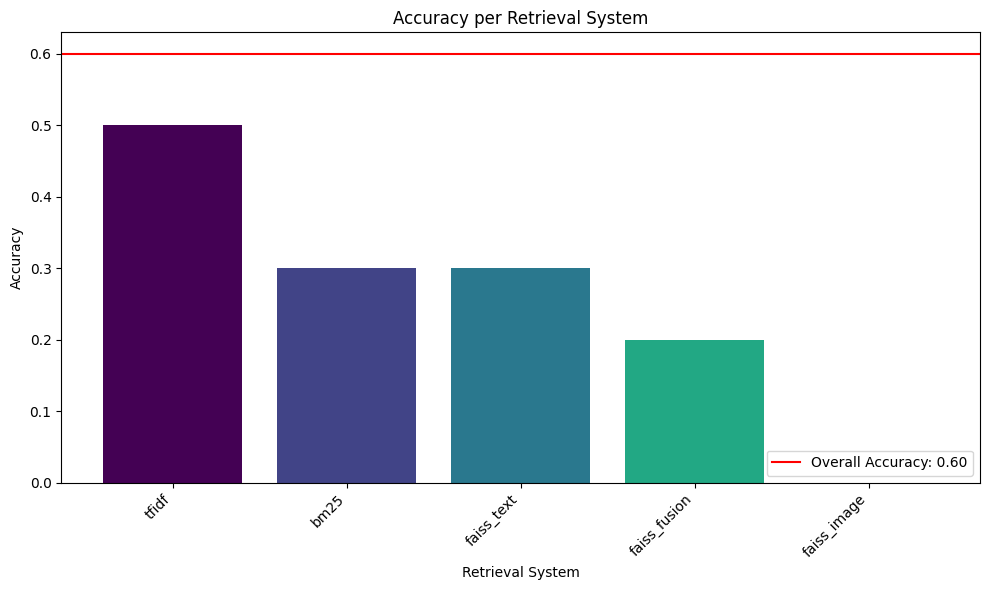

Saved accuracy visualization to /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/evaluation/accuracy_per_system.png
Rejection quality: 0.00 (0/5)
Saved rejection quality visualization to /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/evaluation/rejection_quality.png


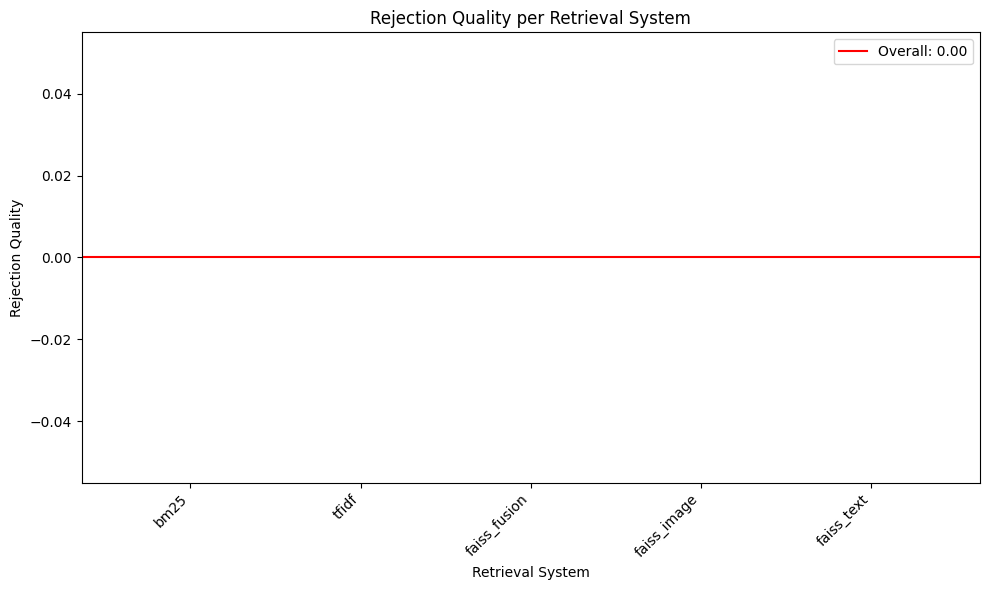


Retrieval system comparison:
- faiss_text: Used in 15/15 questions, Avg score: 0.8038, Avg latency: 0.7271ms
- faiss_image: Used in 15/15 questions, Avg score: 0.3154, Avg latency: 0.6113ms
- faiss_fusion: Used in 15/15 questions, Avg score: 0.6733, Avg latency: 1.2175ms
- tfidf: Used in 15/15 questions, Avg score: 0.3100, Avg latency: 2.5287ms
- bm25: Used in 15/15 questions, Avg score: 9.1276, Avg latency: 1.6515ms


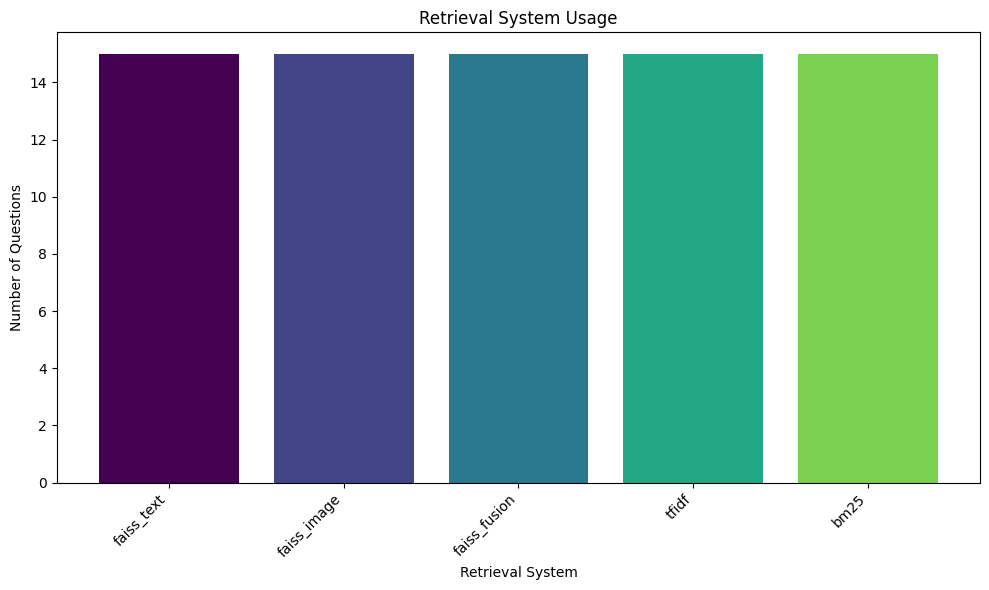

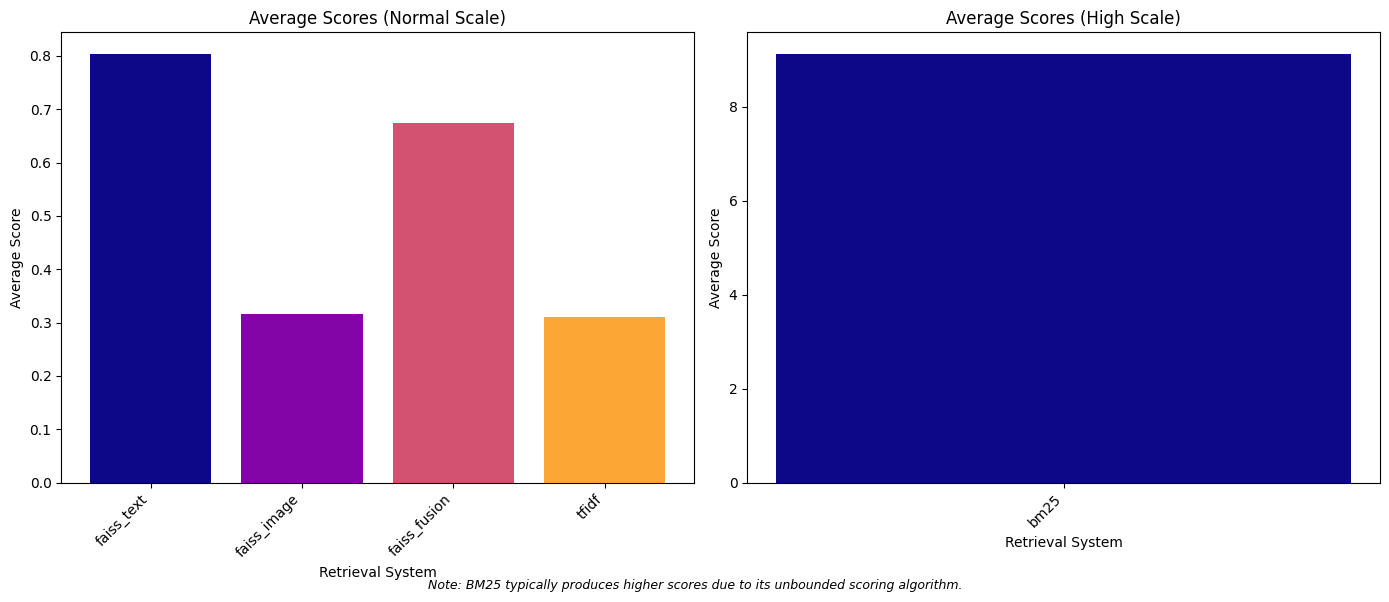

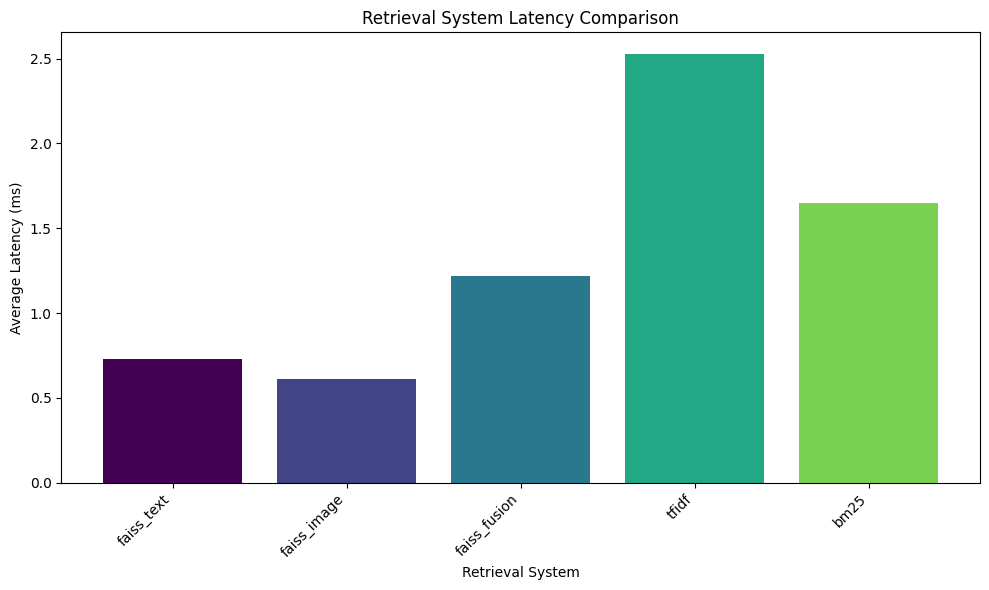

Saved retrieval system visualizations to /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/evaluation

Overall system accuracy: 0.40 (6/15)
Saved overall performance visualization to /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/evaluation/overall_performance.png

Evaluation completed. Results saved to /content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/evaluation/evaluation_report.md


In [77]:
video_path = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/source_video.mp4"
output_dir = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset"
rag_system = VideoRAGSystem(output_dir, video_path)

print("\n=== Running full evaluation on all questions ===\n")

first_set_path = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/Questions/First_set.json"
first_set_results = test_with_qa_set(rag_system, first_set_path)

second_set_path = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/Questions/Second_set.json"
second_set_results = test_with_qa_set(rag_system, second_set_path)

evaluation_output_dir = f"{output_dir}/evaluation"
metrics = evaluate_video_rag_system(
    first_set_results,
    second_set_results,
    output_dir=evaluation_output_dir
)

## UI

In [3]:
%%writefile /content/improved_app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import os
import base64
from PIL import Image

# Configure page
st.set_page_config(page_title="Video Question Answering", layout="wide")

# Setup paths
output_dir = "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset"
video_path = f"{output_dir}/source_video.mp4"
first_set_path = f"{output_dir}/Questions/First_set.json"
second_set_path = f"{output_dir}/Questions/Second_set.json"

# ===== Session State Setup =====
if 'video_timestamp' not in st.session_state:
    st.session_state.video_timestamp = 0
if 'video_key' not in st.session_state:
    st.session_state.video_key = 0
if 'current_question' not in st.session_state:
    st.session_state.current_question = None
if 'current_answer' not in st.session_state:
    st.session_state.current_answer = None
if 'current_segments' not in st.session_state:
    st.session_state.current_segments = {}
if 'current_timespan' not in st.session_state:
    st.session_state.current_timespan = None
if 'answer_history' not in st.session_state:
    st.session_state.answer_history = []
if 'processing' not in st.session_state:
    st.session_state.processing = False

# Function to set video timestamp and force refresh
def set_video_position(timestamp):
    st.session_state.video_timestamp = timestamp
    # Increment key to force video reload
    st.session_state.video_key += 1
    st.rerun()

# Function to load questions
def load_questions():
    questions = []

    # Load answerable questions
    try:
        with open(first_set_path, 'r') as f:
            data = json.load(f)
            for q in data.get("qa", []):
                q["answerable"] = True
                questions.append(q)
    except Exception as e:
        st.error(f"Error loading answerable questions: {e}")

    # Load unanswerable questions
    try:
        with open(second_set_path, 'r') as f:
            data = json.load(f)
            for q in data.get("unanswerable", []):
                q["answerable"] = False
                questions.append(q)
    except Exception as e:
        st.error(f"Error loading unanswerable questions: {e}")

    return questions

# Function to process a question
def process_question(question):
    # Set processing state
    st.session_state.processing = True

    st.write("➡️ Writing question file to:", '/content/streamlit_question.txt')

    # Write the question to a file for the notebook to pick up
    with open('/content/streamlit_question.txt', 'w') as f:
        f.write(question)

    # Create a placeholder for the processing message
    processing_placeholder = st.empty()
    processing_placeholder.info(f"Processing question: {question}...")

    # Wait for the notebook to process the question
    start_time = time.time()
    max_wait_time = 90  # 90 second timeout

    while time.time() - start_time < max_wait_time:
        if os.path.exists('/content/streamlit_answer.json'):
            try:
                # Read the answer
                with open('/content/streamlit_answer.json', 'r') as f:
                    result = json.load(f)

                # Remove the answer file to avoid reading stale data
                try:
                    os.remove('/content/streamlit_answer.json')
                except:
                    pass

                # Clear the processing message
                processing_placeholder.empty()

                # Update session state
                st.session_state.current_question = question
                st.session_state.current_answer = result.get("answer")
                st.session_state.current_combined_answer = result.get("combined_answer")
                st.session_state.current_segments = result.get("segments", {})
                st.session_state.current_timespan = result.get("timespan")

                # Add to history
                st.session_state.answer_history.append({
                    "question": question,
                    "answer": result.get("answer"),
                    "combined_answer": result.get("combined_answer"),
                    "timespan": result.get("timespan"),
                    "segments": result.get("segments", {})
                })

                # Set video timestamp specifically from FAISS text model if available
                segments = result.get("segments", {})
                faiss_text_segments = [(name, segment) for name, segment in segments.items()
                                      if "faiss_text" in name.lower()]

                if faiss_text_segments:
                    # Sort by score and get the best FAISS text result
                    faiss_text_segments.sort(key=lambda x: x[1].get('score', 0), reverse=True)
                    best_segment = faiss_text_segments[0][1]
                    st.session_state.video_timestamp = best_segment.get('start_time', 0)
                    st.session_state.video_key += 1  # Force video reload
                elif result.get("timespan"):
                    # Fallback to overall timespan if no FAISS text model
                    st.session_state.video_timestamp = result.get("timespan")[0]
                    st.session_state.video_key += 1

                # Clear processing state
                st.session_state.processing = False
                return True
            except Exception as e:
                processing_placeholder.error(f"Error processing answer: {str(e)}")
                time.sleep(0.5)

        time.sleep(0.5)

    # If we reach here, there was a timeout
    processing_placeholder.error("Request timed out. Please check the notebook for errors.")
    st.session_state.processing = False
    return False

# Function to display metrics
def display_metrics(segments):
    if not segments:
        st.warning("No retrieval results available")
        return

    models = []
    scores = []

    for model_name, segment in segments.items():
        models.append(model_name)
        scores.append(segment.get("score", 0))

    # Create dataframe and sort
    df = pd.DataFrame({
        "Model": models,
        "Score": scores
    }).sort_values("Score", ascending=False)

    # Plot bar chart
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(df["Model"], df["Score"], color=plt.cm.viridis(np.linspace(0, 0.8, len(models))))

    ax.set_xlabel("Retrieval Model")
    ax.set_ylabel("Score")
    ax.set_title("Retrieval Model Performance Comparison")

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    st.pyplot(fig)

# Function to display segment details
def display_segment(model_name, segment):
    with st.expander(f"{model_name.upper()} - Score: {segment.get('score', 0):.4f}", expanded=True):
        start_time = segment.get('start_time', 0)
        end_time = segment.get('end_time', 0)
        st.markdown(f"**Time Range:** {start_time:.2f}s - {end_time:.2f}s")

        # Play button - simplified to just one button
        if st.button(f"▶️ Play Segment", key=f"play_{model_name}_{start_time}"):
            set_video_position(start_time)

        # Show model's answer more prominently
        st.markdown("**Model's Answer Segment:**")
        text = segment.get('text', 'No text available')
        st.markdown(f"<div style='background-color:#e6f3ff; padding:15px; border-radius:5px; font-size:16px;'>{text}</div>",
                  unsafe_allow_html=True)

        # Display keyframe if available
        if 'keyframe_path' in segment and os.path.exists(segment['keyframe_path']):
            try:
                st.markdown("**Keyframe:**")
                img = Image.open(segment['keyframe_path'])
                st.image(img, caption=f"Keyframe at {segment.get('keyframe_timestamp', segment.get('start_time', 0)):.2f}s", width=400)
            except Exception as e:
                st.error(f"Could not display keyframe: {e}")

# Function to display timeline visualization
def visualize_timespans(segments):
    if not segments:
        return

    # Extract timestamps
    model_timespans = {}
    min_time = float('inf')
    max_time = 0

    for model_name, segment in segments.items():
        start = segment.get('start_time', 0)
        end = segment.get('end_time', 0)
        model_timespans[model_name] = (start, end)

        if start < min_time:
            min_time = start
        if end > max_time:
            max_time = end

    # Add padding
    padding = (max_time - min_time) * 0.1
    min_time = max(0, min_time - padding)
    max_time = max_time + padding

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 3))

    # Set axis limits
    ax.set_xlim(min_time, max_time)
    ax.set_ylim(0, len(model_timespans) + 1)  # +1 for padding

    # Plot model timespans
    y_pos = 1
    for model_name, (start, end) in model_timespans.items():
        ax.barh(y_pos, end - start, left=start, height=0.5,
                color=plt.cm.viridis(0.2 + 0.7 * y_pos / len(model_timespans)),
                alpha=0.7, label=model_name)
        ax.text(start, y_pos, f"  {model_name}", va='center', ha='left', fontsize=9)
        y_pos += 1

    # Set labels
    ax.set_title('Model Timespan Comparison')
    ax.set_xlabel('Time (seconds)')
    ax.set_yticks([])

    # Remove y-axis
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add gridlines
    ax.grid(axis='x', linestyle='--', alpha=0.3)

    st.pyplot(fig)

# Function to calculate combined timespan
def calculate_best_timespan(segments):
    if not segments:
        return None

    weighted_start = 0
    weighted_end = 0
    total_weight = 0
    all_starts = []
    all_ends = []

    # Calculate weighted average
    for model_name, segment in segments.items():
        score = segment.get('score', 0)
        start = segment.get('start_time', 0)
        end = segment.get('end_time', 0)

        all_starts.append(start)
        all_ends.append(end)

        # Use score as weight
        weighted_start += start * score
        weighted_end += end * score
        total_weight += score

    if total_weight > 0:
        # Weighted average based on confidence
        avg_start = weighted_start / total_weight
        avg_end = weighted_end / total_weight

        # Calculate expanded timespan (min start, max end)
        min_start = min(all_starts)
        max_end = max(all_ends)

        return {
            "weighted": (avg_start, avg_end),
            "expanded": (min_start, max_end)
        }
    else:
        return None

# Main UI Layout
st.title("Multimodal RAG System for Video Question Answering")
st.markdown("**Final Assignment Implementation** | LLMs and RAG Systems")

# Two-column layout
col1, col2 = st.columns([3, 2])

with col1:
    # Video player
    st.header("Video Player")
    try:
        # We use the video_key to force reload of the video when timestamp changes
        video_file = open(video_path, 'rb')
        video_bytes = video_file.read()
        video_file.close()
        st.video(video_bytes, start_time=int(st.session_state.video_timestamp))

        # Display current timestamp
        if st.session_state.video_timestamp > 0:
            st.info(f"🕒 Video positioned at: {st.session_state.video_timestamp:.2f}s")
    except Exception as e:
        st.error(f"Error loading video: {e}")

    # Display current results
    if st.session_state.current_question:
        st.header("Results")

        # Display current question
        st.subheader(f"Question: {st.session_state.current_question}")

        # Display combined LLM answer if available
        if hasattr(st.session_state, 'current_combined_answer') and st.session_state.current_combined_answer:
            st.subheader("LLM Combined Answer")
            st.markdown(f"<div style='background-color:#f0f7ff; padding:15px; border-radius:8px; margin-bottom:20px; font-size:18px;'>{st.session_state.current_combined_answer}</div>",
                      unsafe_allow_html=True)

        # Calculate best timespan
        best_timespan = calculate_best_timespan(st.session_state.current_segments)

        # Display timespan visualization
        st.subheader("Timeline Visualization")
        if st.session_state.current_segments:
            # Timeline visualization without final answer
            visualize_timespans(st.session_state.current_segments)

        # Display retrieval metrics
        st.subheader("Retrieval Performance")
        display_metrics(st.session_state.current_segments)

        # Display individual model results with FAISS first
        st.subheader("Model Results")

        if st.session_state.current_segments:
            # Sort segments by prioritizing FAISS text first, then other FAISS models, then others
            sorted_segments = []

            # First add FAISS text models
            faiss_text_segments = [(name, segment) for name, segment in st.session_state.current_segments.items()
                                 if "faiss_text" in name.lower()]
            faiss_text_segments.sort(key=lambda x: x[1].get('score', 0), reverse=True)
            sorted_segments.extend(faiss_text_segments)

            # Then add other FAISS models
            other_faiss_segments = [(name, segment) for name, segment in st.session_state.current_segments.items()
                                  if "faiss" in name.lower() and "faiss_text" not in name.lower()]
            other_faiss_segments.sort(key=lambda x: x[1].get('score', 0), reverse=True)
            sorted_segments.extend(other_faiss_segments)

            # Then add remaining models
            other_segments = [(name, segment) for name, segment in st.session_state.current_segments.items()
                             if "faiss" not in name.lower()]
            other_segments.sort(key=lambda x: x[1].get('score', 0), reverse=True)
            sorted_segments.extend(other_segments)

            for model_name, segment in sorted_segments:
                display_segment(model_name, segment)
        else:
            st.warning("No model results available")

with col2:
    st.header("Ask a Question")

    # Disable inputs while processing
    if st.session_state.processing:
        input_disabled = True
        input_placeholder = "Processing question... please wait"
    else:
        input_disabled = False
        input_placeholder = "Enter your question about the video"

    # Text input for questions
    question_input = st.text_input("Enter your question about the video",
                                  value="",
                                  key="question_input",
                                  disabled=input_disabled,
                                  placeholder=input_placeholder)

    # Submit button
    submit_button = st.button("Submit Question",
                             key="submit_button",
                             disabled=input_disabled)

    if submit_button and question_input and not st.session_state.processing:
        if process_question(question_input):
            st.rerun()

    # Sample questions from test sets
    st.subheader("Sample Questions")

    # Load test questions
    all_questions = load_questions()

    # Answerable questions
    st.write("**Answerable Questions:**")
    answerable = [q for q in all_questions if q.get("answerable", True)]
    answerable_buttons = []

    for i, q in enumerate(answerable[:5]):  # Display first 5
        question_text = q.get("question", "")
        sample_button = st.button(f"Q{i+1}: {question_text}",
                                 key=f"ans_btn_{i}",
                                 disabled=input_disabled)

        if sample_button and not st.session_state.processing:
            if process_question(question_text):
                st.rerun()

    # Unanswerable questions
    st.write("**Unanswerable Questions:**")
    unanswerable = [q for q in all_questions if not q.get("answerable", True)]

    for i, q in enumerate(unanswerable[:3]):  # Display first 3
        question_text = q.get("question", "")
        sample_button = st.button(f"Q{i+1}: {question_text}",
                                 key=f"unans_btn_{i}",
                                 disabled=input_disabled)

        if sample_button and not st.session_state.processing:
            if process_question(question_text):
                st.rerun()

    # Show answer history
    if st.session_state.answer_history:
        st.subheader("Question History")
        for i, item in enumerate(reversed(st.session_state.answer_history)):
            with st.expander(f"Q: {item['question']}"):
                if 'combined_answer' in item and item['combined_answer']:
                    st.markdown(f"**Combined Answer:** {item['combined_answer']}")
                else:
                    st.markdown(f"**Answer:** {item['answer']}")
                if item['timespan']:
                    st.markdown(f"**Timespan:** {item['timespan'][0]:.2f}s - {item['timespan'][1]:.2f}s")
                    if st.button(f"▶️ Play", key=f"history_{i}"):
                        set_video_position(item['timespan'][0])

    # System information
    with st.expander("System Information"):
        st.markdown("""
        ### Multimodal RAG System Architecture

        This system uses multiple retrieval techniques to answer questions about the video:

        - **Text Retrieval**: FAISS and pgvector for transcript text
        - **Image Retrieval**: CLIP embeddings for visual content
        - **Fusion Techniques**: Text and image results combined
        - **Lexical Retrieval**: TF-IDF and BM25 for keyword matching

        The system uses a text+visual modality approach to give more accurate and relevant answers.
        """)

        # Evaluation information
        st.markdown("""
        ### Evaluation Methodology

        The system is evaluated using:

        - **Accuracy**: Correct answers for answerable questions
        - **Rejection Quality**: Correctly identifying unanswerable questions
        - **Retrieval Effectiveness**: Comparing performance of different retrieval methods
        - **Latency**: Processing time for each query

        The test set includes both answerable and unanswerable questions.
        """)

Writing /content/improved_app.py


In [4]:
%%writefile /content/improved_processor.py
"""
Improved direct processor for Streamlit questions
"""
import sys
import os
import json
import time
import threading
from video_rag_system import VideoRAGSystem


# Global variables for tracking processor status
processor_running = True
questions_processed = 0

def run_processor():
    """Process questions from Streamlit using VideoRAGSystem"""
    global processor_running, questions_processed

    print("Starting improved question processor...")

    # Import VideoRAGSystem directly in the notebook's context
    try:
        from video_rag_system import VideoRAGSystem
        print("✅ Successfully imported VideoRAGSystem from notebook")

        def monitor_questions():
            """Thread function to monitor for questions"""
            global processor_running, questions_processed

            print("Starting question monitor thread...")

            while processor_running:
                try:
                    # Check if there's a question file
                    if os.path.exists('/content/streamlit_question.txt'):
                        try:
                            # Read the question
                            with open('/content/streamlit_question.txt', 'r') as f:
                                question = f.read().strip()

                            # Delete the question file immediately
                            os.remove('/content/streamlit_question.txt')

                            if question:
                                print(f"\n==========================================")
                                print(f"Processing question #{questions_processed + 1}: {question}")
                                print(f"==========================================")

                                # Initialize a fresh RAG system for each question
                                rag_system = VideoRAGSystem(
                                    "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset",
                                    "/content/drive/MyDrive/LLMs and RAG Systems/Assignment_5/Dataset/source_video.mp4"
                                )

                                # Process the question
                                print("Using VideoRAGSystem to answer...")
                                start_time = time.time()
                                result = rag_system.answer_question(question)
                                processing_time = time.time() - start_time
                                print(f"Question processed in {processing_time:.2f} seconds!")

                                # Now we need to send the top 3 model answers to the LLM
                                segments = result.get("segments", {})

                                # Prioritize models: FAISS text first, then other FAISS, then others
                                faiss_text_segments = [(name, segment) for name, segment in segments.items()
                                                     if "faiss_text" in name.lower()]
                                other_faiss_segments = [(name, segment) for name, segment in segments.items()
                                                      if "faiss" in name.lower() and "faiss_text" not in name.lower()]
                                other_segments = [(name, segment) for name, segment in segments.items()
                                                 if "faiss" not in name.lower()]

                                # Sort each group by score
                                faiss_text_segments.sort(key=lambda x: x[1].get('score', 0), reverse=True)
                                other_faiss_segments.sort(key=lambda x: x[1].get('score', 0), reverse=True)
                                other_segments.sort(key=lambda x: x[1].get('score', 0), reverse=True)

                                # Combine and take top 3
                                all_segments = faiss_text_segments + other_faiss_segments + other_segments
                                top_segments = all_segments[:3]

                                if top_segments:
                                    print(f"Sending top {len(top_segments)} model answers to LLM...")

                                    # Prepare context for LLM
                                    context = ""
                                    for i, (model_name, segment) in enumerate(top_segments):
                                        text = segment.get('text', 'No text available')
                                        context += f"MODEL {i+1} ({model_name}): {text}\n\n"

                                    # Create LLM prompt
                                    prompt = f"""Based on the following model answers, provide a comprehensive answer to this question: "{question}"

{context}

Answer the question directly based on these model outputs, focusing on the most relevant and accurate information across all models. If the models provide conflicting information, please note that in your answer."""

                                    # Generate answer with LLM
                                    try:
                                        llm_answer = rag_system.generate_with_flan(prompt, max_length=150)
                                        if llm_answer:
                                            print(f"Generated combined answer using all models!")
                                            result["combined_answer"] = llm_answer
                                        else:
                                            print("LLM generation failed, using best model answer as fallback")
                                            # Fallback to best model's text
                                            result["combined_answer"] = top_segments[0][1].get('text', 'No answer available')
                                    except Exception as e:
                                        print(f"Error generating combined answer: {e}")
                                        # Fallback to best model's text
                                        result["combined_answer"] = top_segments[0][1].get('text', 'No answer available')
                                else:
                                    print("No segments available for LLM answer generation")
                                    result["combined_answer"] = "No relevant information found in the video."

                                # Display a summary of the results
                                if result:
                                    answer_preview = result.get('combined_answer', 'No answer available')
                                    if len(answer_preview) > 100:
                                        answer_preview = answer_preview[:100] + "..."
                                    print(f"Combined answer: {answer_preview}")
                                    print(f"Retrieved {len(segments)} segments from different models")
                                else:
                                    print("Warning: VideoRAGSystem returned None or empty result")

                                # Save the result for Streamlit
                                output = {
                                    "answer":           result["combined_answer"],
                                    #"gen_time":         gen_time,
                                    "segments":         result["segments"],
                                    "system_results":   result["system_results"]
                                }
                                with open('/content/streamlit_answer.json', 'w') as f:
                                    json.dump(result, f)

                                print("Answer saved for Streamlit!")
                                questions_processed += 1
                                print(f"Total questions processed: {questions_processed}")
                                print(f"==========================================\n")

                        except Exception as e:
                            print(f"Error processing question: {e}")
                            import traceback
                            traceback_str = traceback.format_exc()
                            print(f"Traceback: {traceback_str}")

                            # Create error response
                            error_response = {
                                "answer": f"Error processing question: {str(e)}",
                                "has_answer": False,
                                "segments": {},
                                "timespan": None
                            }

                            # Save error response
                            with open('/content/streamlit_answer.json', 'w') as f:
                                json.dump(error_response, f)

                except Exception as e:
                    print(f"Error in monitor loop: {e}")

                # Sleep to avoid high CPU usage
                time.sleep(0.5)

            print("Question monitor thread stopped")

        # Start the monitor thread
        monitor_thread = threading.Thread(target=monitor_questions)
        monitor_thread.daemon = True
        monitor_thread.start()

        print("✅ Question processor is running in a background thread")
        print("Ready to process multiple questions from Streamlit")

        from IPython.display import display, HTML
        display(HTML("""
        <div style="background-color:#d4edda; color:#155724; padding:15px; border-radius:5px; margin-bottom:10px;">
            <h3>✅ Improved Question Handler Active</h3>
            <p>The notebook is now handling questions from the Streamlit app.</p>
            <p>You can now use the Streamlit app to ask multiple questions about the video.</p>
            <p><strong>New:</strong> The system now combines the top 3 model answers using the LLM!</p>
        </div>
        """))

        return monitor_thread

    except Exception as e:
        print(f"❌ Critical error starting processor: {e}")
        import traceback
        traceback_str = traceback.format_exc()
        print(f"Traceback: {traceback_str}")
        return None

# Run the processor
monitor_thread = run_processor()

Writing /content/improved_processor.py


In [5]:
%%writefile /content/improved_launcher.py
"""
Improved launcher for the Video RAG System
"""
from google.colab import output
import subprocess
import time
import os
import signal

# Function to kill any existing Streamlit processes
def kill_streamlit():
    print("Stopping any existing Streamlit processes...")
    try:
        # Find Streamlit processes
        ps_output = subprocess.check_output("ps aux | grep streamlit", shell=True).decode()
        for line in ps_output.split('\n'):
            if 'streamlit run' in line:
                try:
                    pid = int(line.split()[1])
                    print(f"Killing Streamlit process with PID {pid}")
                    os.kill(pid, signal.SIGTERM)
                except:
                    pass
    except:
        print("No Streamlit processes found")

    # Give processes time to terminate
    time.sleep(2)

# Clean up existing files
def clean_up_files():
    print("Cleaning up communication files...")
    files_to_remove = [
        '/content/streamlit_question.txt',
        '/content/streamlit_answer.json'
    ]

    for file_path in files_to_remove:
        if os.path.exists(file_path):
            try:
                os.remove(file_path)
                print(f"Removed {file_path}")
            except Exception as e:
                print(f"Could not remove {file_path}: {e}")

# Main launcher function
def launch_system():
    # Clean up
    kill_streamlit()
    clean_up_files()

    # Start the question processor
    print("\n==== Starting Question Processor ====")
    try:
        # Execute the processor in the notebook context
        exec(open('/content/improved_processor.py').read())
        print("✓ Question processor started successfully")
    except Exception as e:
        print(f"❌ Error starting processor: {e}")
        import traceback
        traceback.print_exc()
        return False

    # Start Streamlit
    print("\n==== Starting Streamlit App ====")
    try:
        streamlit_process = subprocess.Popen(
            ["streamlit", "run", "/content/improved_app.py",
             "--server.port=8501",
             "--server.headless=true",
             "--server.enableCORS=false",
             "--server.enableXsrfProtection=false"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )

        # Check if Streamlit started successfully
        time.sleep(5)
        if streamlit_process.poll() is not None:
            print(f"❌ Streamlit failed to start (return code: {streamlit_process.returncode})")
            stderr = streamlit_process.stderr.read().decode()
            print(f"Error: {stderr}")
            return False

        print("✓ Streamlit app started successfully")
    except Exception as e:
        print(f"❌ Error starting Streamlit: {e}")
        import traceback
        traceback.print_exc()
        return False

    # Open Streamlit in a new window
    print("\n==== Opening Streamlit App ====")
    try:
        output.serve_kernel_port_as_window(8501)
        print("✓ Streamlit app opened in new window")
    except Exception as e:
        print(f"⚠️ Could not open Streamlit in a new window: {e}")
        print("You can access Streamlit at: http://localhost:8501")

    # Success message
    print("\n✅ SYSTEM RUNNING SUCCESSFULLY!")
    print("The question processor is active in the notebook")
    print("The Streamlit app is running and ready to use")
    print("\nYou can now:")
    print("1. Type your own questions in the text input")
    print("2. Select from sample questions in the UI")
    print("3. See results from each retrieval model")
    print("4. Play video segments at the identified timestamps")

    return True

# Run the launcher
if __name__ == "__main__":
    launch_system()

Writing /content/improved_launcher.py


In [2]:
%run /content/improved_app.py

2025-05-11 14:56:46.388 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 14:56:46.390 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 14:56:46.391 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-05-11 14:56:46.392 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 14:56:46.393 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 14:56:46.394 WARNING streamlit.runtime.scriptrunner_utils.script_run_c

In [3]:
%run /content/improved_processor.py

Starting improved question processor...
✅ Successfully imported VideoRAGSystem from notebook
Starting question monitor thread...
✅ Question processor is running in a background thread
Ready to process multiple questions from Streamlit



Processing question #1: Who is the student among the co-authors?
Loading FLAN-T5-large model


In [2]:
!watch -n 2 ls -l /content/streamlit_answer.json

>

In [9]:
%run "/content/improved_launcher.py"

Stopping any existing Streamlit processes...
Cleaning up communication files...
Removed /content/streamlit_answer.json

==== Starting Question Processor ====
Starting improved question processor...
✅ Successfully imported VideoRAGSystem from notebook
❌ Critical error starting processor: name 'threading' is not defined
Traceback: Traceback (most recent call last):
  File "<string>", line 165, in run_processor
NameError: name 'threading' is not defined

✓ Question processor started successfully

==== Starting Streamlit App ====
✓ Streamlit app started successfully

==== Opening Streamlit App ====
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

✓ Streamlit app opened in new window

✅ SYSTEM RUNNING SUCCESSFULLY!
The question processor is active in the notebook
The Streamlit app is running and ready to use

You can now:
1. Type your own questions in the text input
2. Select from sample questions in the UI
3. See results from each retrieval model
4. Play video segments at the identified timestamps


In [4]:
!which streamlit
!streamlit --version


/usr/local/bin/streamlit
Streamlit, version 1.45.0


In [4]:
!python /content/improved_launcher.py


✅ SentenceTransformer loaded successfully


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ CLIP model loaded successfully
Initializing retrieval systems...
Setting up FAISS systems...
Loaded 330 text embeddings
2025-05-11 14:57:03.843228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746975423.862420  103460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746975423.867893  103460 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loaded image embeddings for 329 segments
Loaded 330 text embeddings
Loaded image embeddings for 329 segments
Setting up lexical retrieval systems...
✅ TFIDF initialized
Initializing BM25...
Loaded 330 text embeddings
✅ BM25 initialized
Building index for faiss_text...
FAISS text index built with 330 vectors. Setup

In [15]:
# Force-kill anything listening on 8501
!kill -9 $(lsof -ti:tcp:8501) || echo "No process found on 8501"


lsof: unknown service tcp:8501 in: -i :tcp:8501
lsof 4.93.2
 latest revision: https://github.com/lsof-org/lsof
 latest FAQ: https://github.com/lsof-org/lsof/blob/master/00FAQ
 latest (non-formatted) man page: https://github.com/lsof-org/lsof/blob/master/Lsof.8
 usage: [-?abhKlnNoOPRtUvVX] [+|-c c] [+|-d s] [+D D] [+|-E] [+|-e s] [+|-f[gG]]
 [-F [f]] [-g [s]] [-i [i]] [+|-L [l]] [+m [m]] [+|-M] [-o [o]] [-p s]
 [+|-r [t]] [-s [p:s]] [-S [t]] [-T [t]] [-u s] [+|-w] [-x [fl]] [--] [names]
Use the ``-h'' option to get more help information.
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
No process found on 8501
